<h2> MSDS 458 Assignment </h2>
Author: Dan Oberdorf <br>
Date: January 30, 2025 <br>
Built for Python Version: 3.8.20 (some visualization features may not work for later versions of Python) <br>

This program generates a Multilayer Perceptron (MLP) based off of coded provided in class by AJ Maren and Robert Guenther. This version of the code is for running experiments to test the efficacy of a single hidden layer neural network and determine if using an adaptable dropout layer to improve model generalization and build a model that has better accuracy/lower loss. <br>

Objective: Can we improve accuracy and loss by dynamically changing the number of dropout nodes to see if we can achieve faster convergence. We will measure the "faster" convergence on the number of testing iterations/epochs used. Additionally, we will measure the accuracy and loss based on results using the model against a "test" dataset that the model has not seen previously. <br>

Dataset: __Digits Dataset - sklearn.datasets.load_digits__ <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This is a copy of the test set of the UCI ML hand-written digits datasets<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits<br>

Initial Weights: Randomly selected using weight initialization function in the script.

Base model: Class Code mentioned above + static dropout layer
- 64 input nodes
- 64 hidden nodes (with a subsequent test run at 128)
- 10 output nodes
- Learning Rate and Minimum Error Threshold are fixed at 0.2 and 0.01 for all tests. 

**Changes for Experimental Cases are below.**<br>

Case 1: Static Dropout:
- 64 hidden nodes (128, 256)
- Static Dropout Rate at 0.4

Case 2: Dynamic Dropout:
- 64 hidden nodes (128, 256)
- Dyanmic Dropout Rate

After testing using the courses MLP, I then also did the same work using Keras. 
My goal for the MLP work was to understand the mechanical operations that go into this. This also allowed me to do more work with the activations.


In [1]:
import numpy as np
import pandas as pd
from numpy import savetxt
from IPython.display import display, HTML
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import random
import pickle

import tensorflow as tf

In [2]:
# set cell width
display(HTML("<style>.container { width:100% !important; }</style>"))

# set cell output window height
display(HTML("<style>div.output_scroll { height: 160em;} </style>"))

pd.set_option('display.width', 1000)

%load_ext tensorboard

## MLP Model for MSDS 458 Assignment

#### Class Code based on ds_sync_neural_nets_backpropagation_03_16_2023 by Robert Guenther

In [3]:
# Data Load and testing Test Split Functions
def load_data(data_set):

    # optionality to load two different data sets
    if data_set.lower() == 'iris':
        data = load_iris()
        X=data.data
        y=data.target
    elif data_set.lower() == 'digits':
        # data = load_digits()
        training_data = pd.read_csv('./optical+recognition+of+handwritten+digits/optdigits.tra', header=None)
        test_data = pd.read_csv('./optical+recognition+of+handwritten+digits/optdigits.tes', header=None)
        xtr = training_data.loc[:,:63]
        ytr = training_data.loc[:,64]
        xte = test_data.loc[:,:63]
        yte = test_data.loc[:,64]
        full_x_df = pd.concat([pd.DataFrame(xtr),pd.DataFrame(xte)], axis = 0)
        full_y_df = pd.concat([pd.DataFrame(ytr),pd.DataFrame(yte)], axis = 0)
        full_x_df.columns = ['x'+str(x) for x in full_x_df.columns]
        full_y_df.columns = ['Target']
        X = np.array(full_x_df)
        y = np.ndarray.flatten(np.array(full_y_df))

    print(f'Dimensions of data {X.shape}')

    # normalize data
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    
    # map for three output nodes
    y = pd.get_dummies(y).values
    
    return(X,y)

########################################################

def split_train_test(X, y, test_size, random_state):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y, shuffle=True)
    return(X_train, X_test, y_train, y_test)

In [20]:
def init_weights(loc, scale, seed, input_size, hidden_size, output_size):

    # always randomized unless trying to duplicate results
    # models should have random initial weights 
    np.random.seed(seed)

    # weights input to hidden
    W1 = np.random.normal(loc=loc, scale=scale, size=(input_size, hidden_size))  

    # weights hidden to output
    W2 = np.random.normal(loc=loc, scale=scale, size=(hidden_size , output_size))

    return(W1, W2)


def store_weights(W1, W2, period):

    # save weights for additional analysis if needed or reloading
    # the 'weights' are what is learned
    # options to save both the initial and the final weights 
    print('\nsaving ' + period + ' weights')
    savetxt('./MLP_Weights/W1_' + period + '.csv', W1, delimiter=',')
    savetxt('./MLP_Weights/W2_' + period + '.csv', W2, delimiter=',')

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def mean_squared_error(y_pred, y_true):
    return ((y_pred - y_true)**2).sum() / (2*y_pred.size)
    
def accuracy(y_pred, y_true):
    acc = y_pred.argmax(axis=1) == y_true.argmax(axis=1)
    return acc.mean()

In [6]:
def plot_results(w1f, w1u, w2, w2u, scores):
    # want to plot our results over time to see what is happening during learning
    fig, axs = plt.subplots(3,2, figsize=(20,20))
    fig.tight_layout(pad=15.0)

    # plot current values of input to hidden weights
    axs[0,0].plot(range(w1f.shape[0]),w1f.to_numpy())
    axs[0,0].set_title('\n\nWhat are the current values of the weights?\n\nInput to Hidden Weights Current Values (y axis)\nIterations (x axis)\n\n')
    axs[0,0].axhline(y=0,color='black', linestyle='--')

    # plot current values of updates of input to hidden weights
    axs[0,1].plot(range(w1u.shape[0]),w1u.to_numpy())
    axs[0,1].set_title('\n\nHow much are we adjusting each of the weights?\n\nInput to Hidden Weight Updates (y axis)\nIterations (x axis)\n\n')
    axs[0,1].axhline(y=0,color='black', linestyle='--')

    # plot current values of hidden to output weights
    axs[1,0].plot(range(w2.shape[0]),w2.to_numpy())
    axs[1,0].set_title('\n\n\n\nWhat are the current values of the weights?\n\nHidden to Output Weights Current Values (y axis)\nIterations (x axis)\n\n')
    axs[1,0].axhline(y=0,color='black', linestyle='--')

    # plot current values of updates to hidden to output weights
    axs[1,1].plot(range(w2u.shape[0]),w2u.to_numpy())
    axs[1,1].set_title('\n\n\n\nHow much are we adjusting each of the weights?\n\nHidden to Output Weight Updates (y axis)\nIterations (x axis)\n\n')
    axs[1,1].axhline(y=0,color='black', linestyle='--')

    # plot mse
    axs[2,0].plot(range(scores.shape[0]),scores['mse'])
    axs[2,0].set_title('\n\nMSE (y axis)\nIterations (x axis)\n\n')
    axs[2,0].axhline(y=0,color='white', linestyle='-')

    # plot accuracy
    axs[2,1].plot(range(scores.shape[0]),scores['accuracy'])
    axs[2,1].set_title('\n\nAccuracy (y axis)\nIterations (x axis)\n\n')
    axs[2,1].set_ylim(0,1)

    plt.show()

#### New Code for Dropout Layer by Dan Oberdorf

In [207]:
def dynamic_drop_calc(neuron_count, error_rate, static_rate = None):
    '''
    This function takes the error rate and turns of a proportionate number of neurons based on the error rate. This proportion is based on 1 - error rate (e.g. error rate of 30% turns off 70% of the neurons). Maximum percentage of nodes that can be turned off is 75%. There is a lower bounds on number of neurons turned off it will be the larger of nodes - (1 * mse) or 0.1 * nodes (this just puts a lower bounds at 10% if too many nodes get shut off). For small networks, less than 10 features, only 50% of the nodes can be shut off max. It's also capped at 100% error.
    '''

    if static_rate != None:
        inactive_neurons = round(neuron_count * static_rate)
     
    else:
        if error_rate > 1:
            error_rate = 1
            # print('Warning: Error Rate exceeded 100%, Error Rate set to 100%.')
        elif error_rate < .1:
            error_rate = .1
            # print('Warning: Error Rate less than 10%, Error Rate set to 10%.')

        inactive_neurons = round(neuron_count * (1 - error_rate))

        # this is for networks with few features, making it keep more node on
        if neuron_count < 10 and (inactive_neurons / neuron_count) > .5:
            inactive_neurons = round(neuron_count * .5)

        # max percent of nodes off is 75%
        elif (neuron_count - inactive_neurons) < (neuron_count * .25):
            inactive_neurons = round(neuron_count - (neuron_count * .25))

    return inactive_neurons

In [8]:
def drop_out(weight_array, error_rate, static_dropout_rate = None, seed = None):
    '''
    This function makes two binary arrays one for drop off and one to retain/replace values in the full data set. 
    '''

    neuron_count = weight_array.size
    array_shape = weight_array.shape

    inactive_neurons = dynamic_drop_calc(neuron_count, error_rate, static_dropout_rate)
    ### Node selection area
    np.random.seed(seed)

    off_list = random.sample(range(0,neuron_count),inactive_neurons)

    ### for dropout layer results
    drop_out_array = np.ones(neuron_count)
    drop_out_array[off_list] = 0
    drop_out_array = drop_out_array.reshape(array_shape)

    ### for adjusting full table only
    # keep_in_array = np.zeros(neuron_count)
    # keep_in_array[off_list] = 1
    # keep_in_array = keep_in_array.reshape(array_shape)
    keep_in_array = abs(drop_out_array - 1)

    # print(off_list)

    return drop_out_array, keep_in_array

In [9]:
def drop_out_layer(mod_array, orig_array, error_rate, learning_rate, update_array, static_dropout_rate = None, seed = None):
    '''
    This function does the actual drop out work and prepping of the array for the next iteration.
    '''
    adj_array = mod_array - learning_rate * update_array # adjust the current weights into a temporary array
    drop_array, keep_array = drop_out(orig_array, error_rate, static_dropout_rate, seed) # get randomized dropouts
    next_weights = adj_array * drop_array # next iterations's Weights
    full_weights = (mod_array * keep_array) + next_weights # full data with updated weights
    return next_weights, full_weights

#### Continuation of Class Code of NN with Backprop by R. Guenther with addition of dropout code by D. Oberdorf

**Note:** I have annotated some lines of code differently than the provided code in class. I put these annotations in a form that I respond to.

In [10]:
def AJMRG_MLP(xTr, yTr, N, input_size, hidden_size, output_size, model_name = None, wt_seed = None, drop_out_seed = None, static_drop_out_rate = None):

    ### set params
    learning_rate, iterations, minimum_error_threshold, scores, weights_1, weights_2, weights_1_updates, weights_2_updates = init_params()

    ### if model name contains spaces, change to underscores

    model_name = model_name.replace(' ','_')

    ### initialize weights
    ### W1: Input2Hidden; W2: Hidden2Output

    W1, W2 = init_weights(0, 1, wt_seed, input_size, hidden_size, output_size)
    store_weights(W1, W2, f'initial_{model_name}')

    ########################################################################
    for itr in range(iterations): 

        if itr % int(iterations/10) == 0:
            print('starting iteration {:6.0f} of {:6.0f}'.format(itr, iterations))

        #### For the first iteration, I want to retain copies of original weights to retain a record of the model's work.
        if itr == 0:
            # print('Initial\n',W1,'\n\n')
            W1_orig = W1.copy()
            W2_orig = W2.copy()
            W1_mod = W1.copy()
            W2_mod = W2.copy()
            W1_shape = W1.shape
            W2_shape = W2.shape
            weights_1 = pd.DataFrame(W1.reshape(1,-1))
            weights_2 = pd.DataFrame(W2.reshape(1,-1))
            mse_prior = 0.9 # arbitrary value for epoch 1, all subsequent are based on the prior epoch's mse
            try:
                del(weights_1_full)
                del(weights_2_full)
            except:
                pass
            weights_1_full = pd.DataFrame(W1.reshape(1,-1))
            weights_2_full = pd.DataFrame(W2.reshape(1,-1))
        
        ########################################################################
        ### Forward Run through model
        ### input to hidden layer
        Z1 = np.dot(xTr, W1)
        A1 = sigmoid(Z1)

        ### hidden to output layer
        Z2 = np.dot(A1, W2)
        A2 = sigmoid(Z2)

        ### iteration performance
        mse = mean_squared_error(A2, yTr)
        acc = accuracy(A2, yTr)

        if abs(mse_prior - mse) > minimum_error_threshold:

            ########################################################################
            ### Backpropagation
            ### Hidden to Output Layer First
            ### Error in the Output Layer
            E1 = A2 - yTr
            ### Change
            slope1 = A2 * (1 - A2)
            ### Rate of Change/Gradient of the Output Layer (derivative of W2)
            dW1 = E1 * slope1

            ### Input to Hidden Layer Second
            E2 = np.dot(dW1, W2.T)
            ### Change/Slope and Rate of Change/Gradient (derivative of W1)
            slope2 = A1 * (1 - A1)
            dW2 = E2 * slope2

            ########################################################################
            ### Weight Adjustments for both layers

            W2_update = np.dot(A1.T, dW1) / N
            W1_update = np.dot(xTr.T, dW2) / N

            ########################################################################
            ### Update the Weights for Hidden to Output Layer
            '''
            I am not dropping out W2 weights as, based on my reading and understanding of dropouts, these are only applied to the input to hidden layer. With multi-hidden layer networks, we could do it on more layers but right now, it will only be on the W1 weights.
            '''
            ### Update W2 weights. No hidden nodes here!!!
            W2 = W2 - learning_rate * W2_update

            ### Update W1 with dropouts 
            ### My function has two outputs. The first is the actual weights to be used for the next iteration.
            ### The second output (W1_mod) is for the cumulative weight table
            W1, W1_mod = drop_out_layer(W1_mod, W1_orig, mse, learning_rate, W1_update,
                                        static_dropout_rate = static_drop_out_rate, seed = drop_out_seed)

            ########################################################################
            ### Store Weights and Updates
            ### store weight updates
            row_weights_1_updates = pd.DataFrame(W1_update.reshape(1,-1))
            row_weights_2_updates = pd.DataFrame(W2_update.reshape(1,-1))
            weights_1_updates = pd.concat([weights_1_updates, row_weights_1_updates], ignore_index = True)
            weights_2_updates = pd.concat([weights_2_updates, row_weights_2_updates], ignore_index = True)

            ### store weights used for each iteration
            row_weights_1 = pd.DataFrame(W1.reshape(1,-1))
            row_weights_2 = pd.DataFrame(W2.reshape(1,-1))
            weights_1 = pd.concat([weights_1, row_weights_1], ignore_index = True)
            weights_2 = pd.concat([weights_2, row_weights_2], ignore_index = True)

            ### Progression of Weights for Hidden to Input Layer
            row_weights_1_full = pd.DataFrame(W1_mod.reshape(1,-1))
            weights_1_full = pd.concat([weights_1_full, row_weights_1_full], ignore_index = True)
            
            ### store Training mse and accuracy
            data = [{'mse':mse,'accuracy':acc}]
            data = pd.DataFrame(data, index=[itr])
            scores = pd.concat([scores, data])

        else:
            print(f'Training stopped at itertion no. {iter} as Minimum Error Threshold was met.')
            break
    
    mse_prior = mse

    ### W1 mod is stored as this contains all trained nodes from the network. W2 is as-is.
    store_weights(W1_mod, W2, f'final_{model_name}')
    print('complete')

    ### Return the scores, weight updates, full weights, and running weights
    output_dict = {'weights_1_updates':weights_1_updates,
                   'weights_2_updates':weights_2_updates,
                   'weights_1':weights_1,
                   'weights_2':weights_2,
                   'weights_1_full':weights_1_full,
                   'scores':scores,
                   'final_W1':W1_mod,
                   'final_W2':W2
                   }

    return output_dict

In [11]:
def nn_runner(xTe, yTe, i2h_wts, h2o_wts):

      ### Input to Hidden (Full Weights)
      Z1 = xTe @ i2h_wts
      A1 = sigmoid(Z1)
      ### Hidden to Output
      Z2 = A1 @ h2o_wts
      A2 = sigmoid(Z2)

      acc_f = accuracy(A2, yTe)
      mse_f = mean_squared_error(A2, yTe)

      print(f"Final training accuracy: {'{:.4f}'.format(acc_f)}\n\
            Final loss: {'{:.4f}'.format(mse_f)}")
      
      return acc_f, mse_f

#### Validate that the MLP is operational

In [12]:
def init_params():
    learning_rate = 0.2                 
    iterations = 100                 
    minimum_error_threshold = 0.01      
    #### OUTPUT DATAFRAMES
    scores = pd.DataFrame()             
    weights_1 = pd.DataFrame()          
    weights_2 = pd.DataFrame()          
    weights_1_updates = pd.DataFrame()  
    weights_2_updates = pd.DataFrame()  
    
    return(learning_rate, iterations, minimum_error_threshold, scores, weights_1, weights_2, weights_1_updates, weights_2_updates)

In [13]:
### Load Data
x_iris, y_iris = load_data('iris')

Dimensions of data (150, 4)


In [21]:
### Seed Storage for testing
seed_split = None
seed_wt_init = None
seet_dropout = None

### Dropout Rate
sdr = None

### Split Data
xtr, xte, ytr, yte = split_train_test(x_iris, y_iris, test_size = 0.2, random_state = None)

N = ytr.shape[0]                    
input_size = xtr.shape[1]       
hidden_size = 2 * xtr.shape[1]                     
output_size = ytr.shape[1]       

### Run Network
runx_output = AJMRG_MLP(xtr, ytr, N, input_size, hidden_size, output_size, 'MLP Test 00',seed_wt_init, seet_dropout, sdr)


saving initial_MLP_Test_00 weights
starting iteration      0 of    100
starting iteration     10 of    100
starting iteration     20 of    100
starting iteration     30 of    100
starting iteration     40 of    100
starting iteration     50 of    100
starting iteration     60 of    100
starting iteration     70 of    100
starting iteration     80 of    100
starting iteration     90 of    100

saving final_MLP_Test_00 weights
complete


In [22]:
### Used to check static and dynamic dropout settings to ensure that dropouts are working as expected.

row_ctr = 0
zero_row_max = 0
zero_row_min = runx_output['weights_1'].shape[1]
zero_total_row = 0
zero_avg_row = 0

for row in runx_output['weights_1'].iloc[1:].iterrows():
    zero_ct = row[1][row[1] == 0].count()
    if zero_ct > 0:
        row_ctr += 1
        if zero_ct > zero_row_max:
            zero_row_max = zero_ct
        elif zero_ct < zero_row_min:
            zero_row_min = zero_ct
        else:
            pass
    zero_total_row += zero_ct

zero_avg_row = zero_total_row / runx_output['weights_1'].iloc[1:].shape[0]

if sdr == None:
    do_type = 'Dynamic'
else:
    do_type = 'Static'

print(f'{do_type} Drop Out Layer\nNumber of Rows with Dropouts: {row_ctr}\nAverage Number of Dropouts per Row: {zero_avg_row}\nMaximum Dropouts: {zero_row_max}\nMinimum Dropouts: {zero_row_min}')

Dynamic Drop Out Layer
Number of Rows with Dropouts: 100
Average Number of Dropouts per Row: 27.99
Maximum Dropouts: 28
Minimum Dropouts: 27


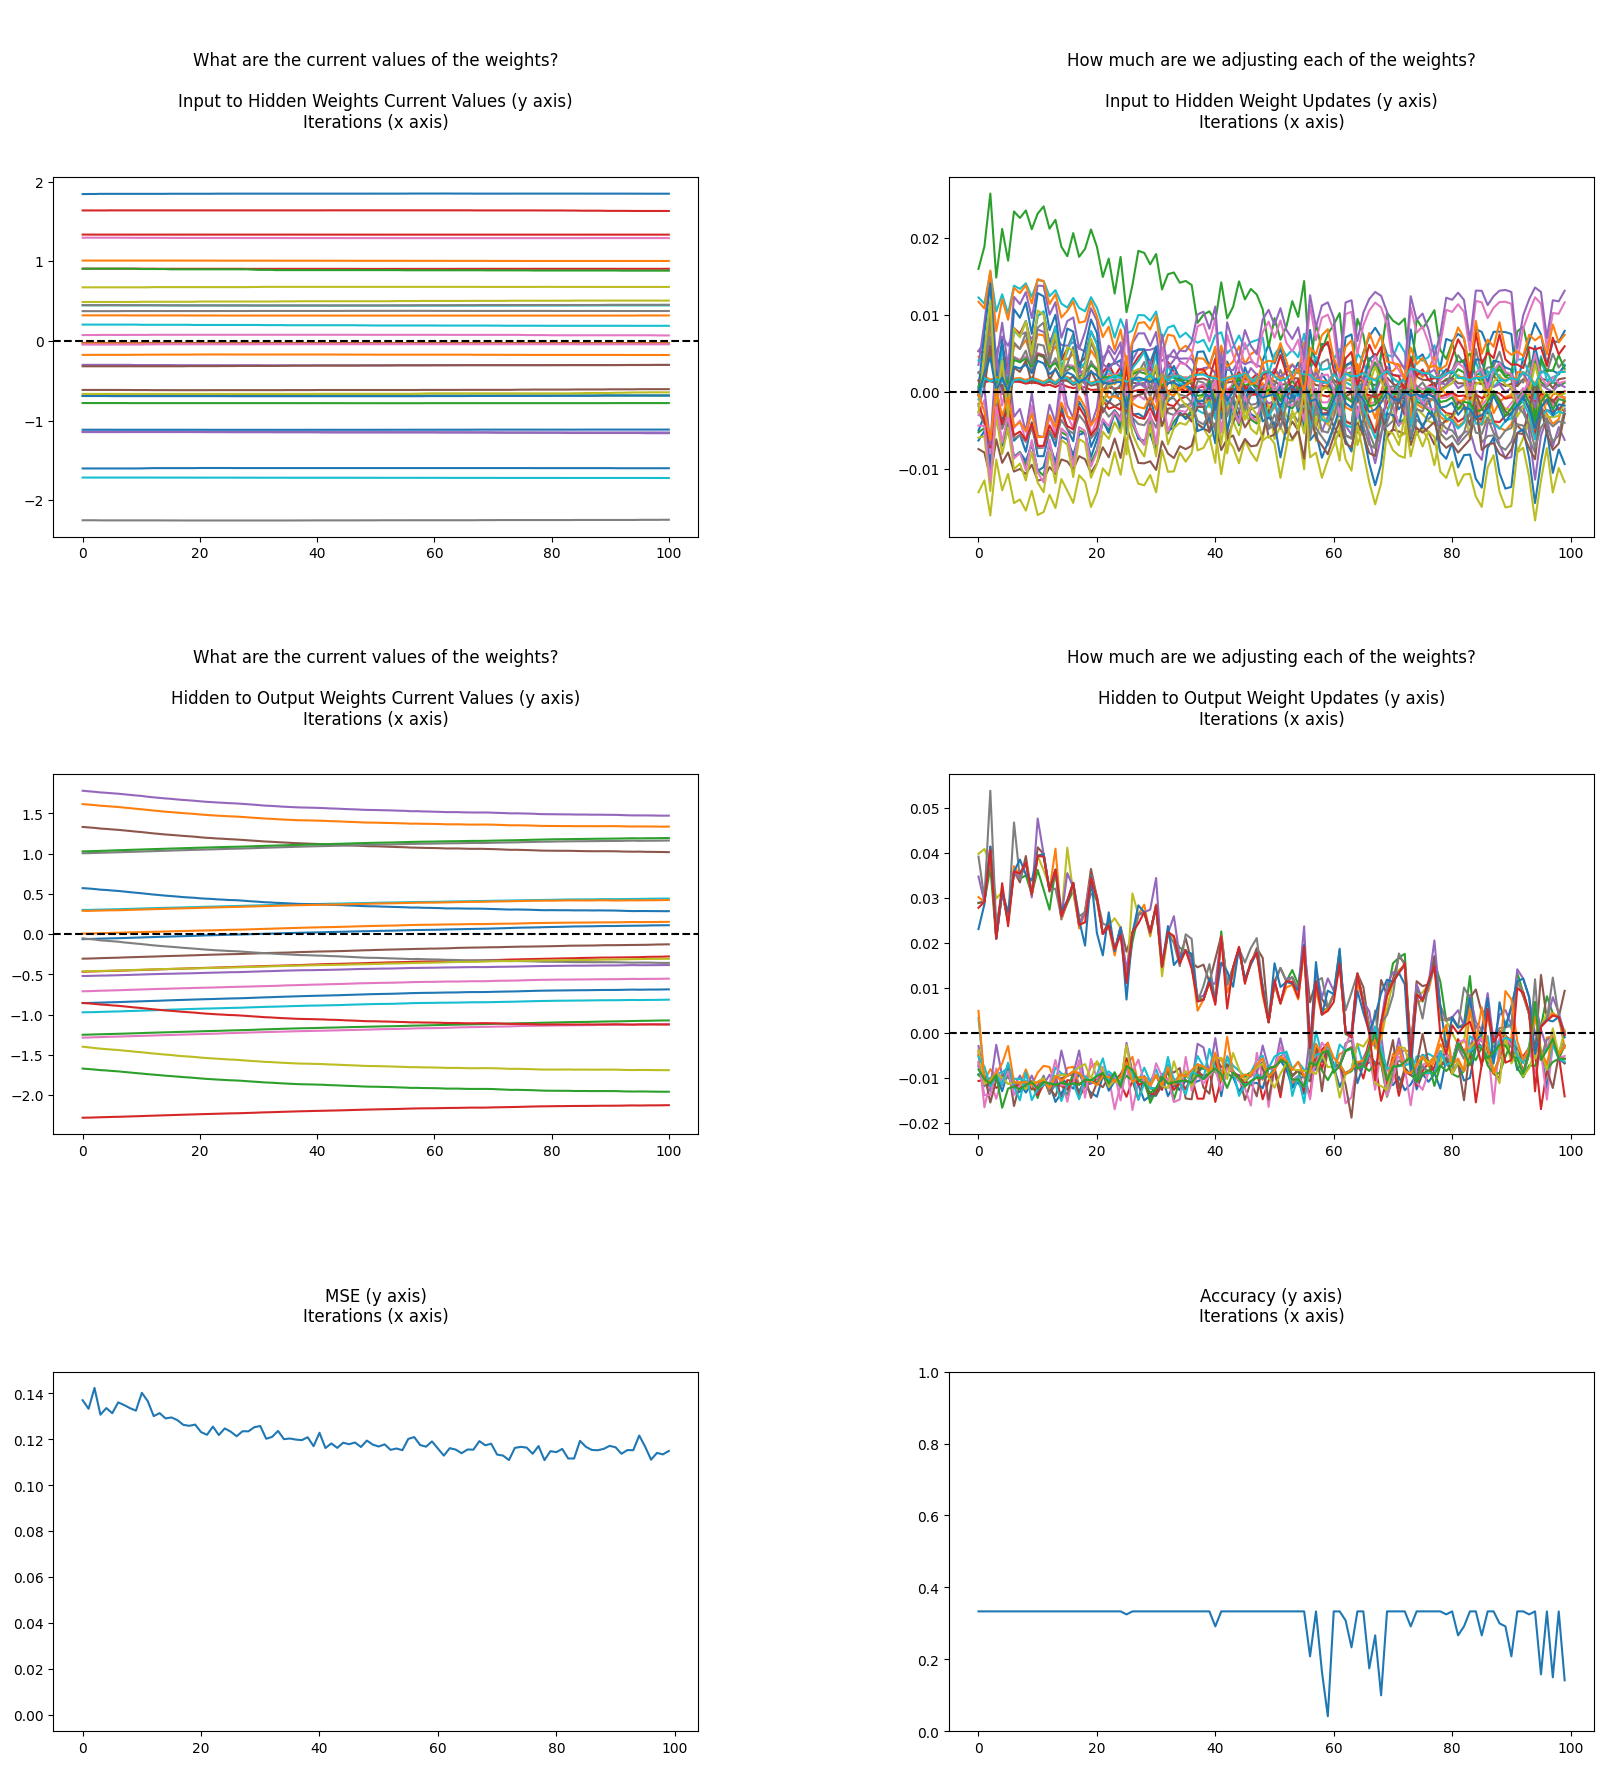

In [23]:
plot_results(runx_output['weights_1_full'],
             runx_output['weights_1_updates'],
             runx_output['weights_2'],
             runx_output['weights_2_updates'],
             runx_output['scores']
             )

##### Final Training Result (using all weights) and Validation Result

In [24]:
### Full Training Accuracy Final using Full Final Training Weights

acc_train, mse_train = nn_runner(xtr, ytr, runx_output['final_W1'], runx_output['final_W2'])


Final training accuracy: 0.3333
            Final loss: 0.1219


In [25]:
### Testing Accuracy Final using Full Final Training Weights

acc_test, mse_test = nn_runner(xte, yte, runx_output['final_W1'], runx_output['final_W2'])

Final training accuracy: 0.3333
            Final loss: 0.1234


### MLP Experiments

In [26]:
def init_params():
    learning_rate = 0.2                 
    iterations = 10000                 
    minimum_error_threshold = 0.001      
    #### OUTPUT DATAFRAMES
    scores = pd.DataFrame()             
    weights_1 = pd.DataFrame()          
    weights_2 = pd.DataFrame()          
    weights_1_updates = pd.DataFrame()  
    weights_2_updates = pd.DataFrame()  
    
    return(learning_rate, iterations, minimum_error_threshold, scores, weights_1, weights_2, weights_1_updates, weights_2_updates)

<h3>The following code is to load and create a single set of training and testing data to allow comparison of different experiments </h3>

In [27]:
### Seed Storage for testing
seed_split = 1

### Load Data
X, y = load_data('digits')

### Split Data
X_train, X_test, y_train, y_test = split_train_test(X, y, test_size = 0.2, random_state = seed_split)

Dimensions of data (5620, 64)


In [30]:
for df in [X_train, X_test, y_train, y_test]:
    print(df.shape)

(4496, 64)
(1124, 64)
(4496, 10)
(1124, 10)


**Before running**<br>
Make sure each output dictionary has a unique name and each model has a distinct name or number

#### Base Case MLP

<h4> Base Case 1 - No Dropout Layer (Hidden Nodes = 2 * # of Input Variables)</h4>

In [31]:
### Seed Storage for testing
# seed_wt_init = 98
# seet_dropout = 11

### Model Name
model_nm = 'mlp_base_01'

### Static Dropout Rate
sdr = 0

N = y_train.size                    
input_size = X_train.shape[1]       
hidden_size = X_train.shape[1] * 2                     
output_size = y_train.shape[1]       

### Run Network
mlp_base_01_output = AJMRG_MLP(X_train, y_train, N, input_size, hidden_size, output_size, model_nm, static_drop_out_rate = sdr)


saving initial_mlp_base_01 weights
starting iteration      0 of  10000
starting iteration   1000 of  10000
starting iteration   2000 of  10000
starting iteration   3000 of  10000
starting iteration   4000 of  10000
starting iteration   5000 of  10000
starting iteration   6000 of  10000
starting iteration   7000 of  10000
starting iteration   8000 of  10000
starting iteration   9000 of  10000

saving final_mlp_base_01 weights
complete


In [32]:
### Full Training Accuracy Final using Full Final Training Weights

acc_train, mse_train = nn_runner(X_train, y_train, mlp_base_01_output['final_W1'], mlp_base_01_output['final_W2'])

Final training accuracy: 0.2569
            Final loss: 0.0406


In [33]:
### Testing Accuracy Final using Full Final Training Weights

acc_test, mse_test = nn_runner(X_test, y_test, mlp_base_01_output['final_W1'], mlp_base_01_output['final_W2'])

Final training accuracy: 0.2616
            Final loss: 0.0405


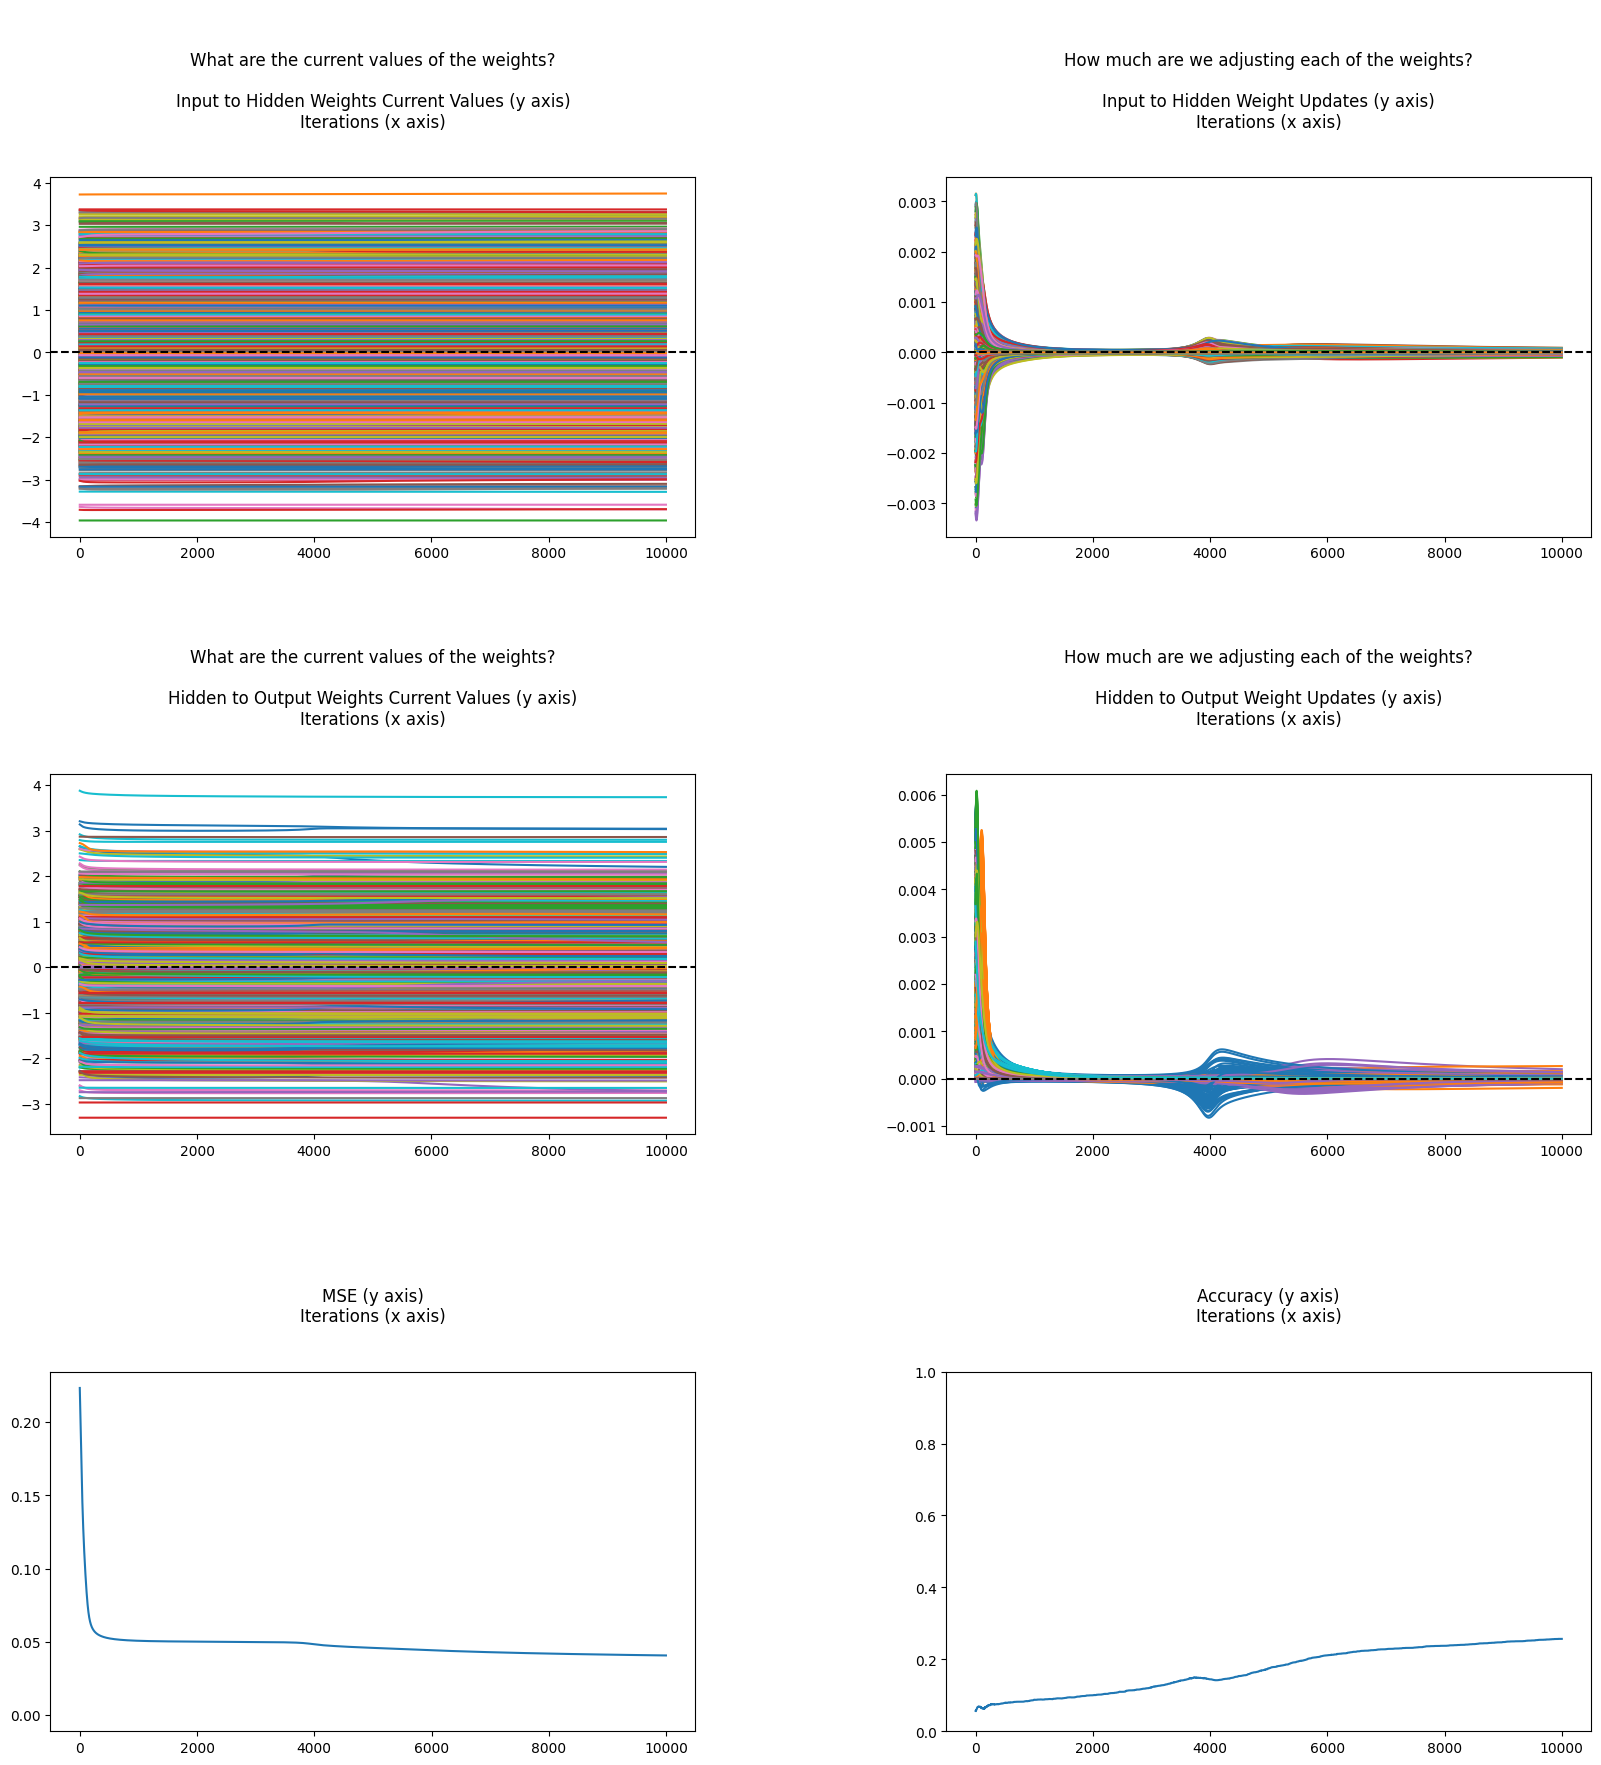

In [34]:
plot_results(mlp_base_01_output['weights_1_full'],
             mlp_base_01_output['weights_1_updates'],
             mlp_base_01_output['weights_2'],
             mlp_base_01_output['weights_2_updates'],
             mlp_base_01_output['scores']
             )

In [35]:
base_1_activations = pd.DataFrame()

for i, j in zip(X_test,y_test):
    # print('Digit Value: ',np.argmax(j))
    Z1 = i @ mlp_base_01_output['final_W1']
    A1 = sigmoid(Z1)
    A1_flat = np.ndarray.flatten(np.round(A1,decimals=3))
    # print(A1_flat)
    Z2 = A1 @ mlp_base_01_output['final_W2']
    A2 = sigmoid(Z2)
    A2_flat = np.ndarray.flatten(np.round(A2,decimals=3))
    # print(A2_flat)
    # print('\n')
    temp_df = pd.DataFrame({'digit_y':[np.argmax(j)],'A1':[A1_flat], 'A2':[A2_flat]})

    base_1_activations = pd.concat([base_1_activations,temp_df], axis = 0, ignore_index=True)



# ### Hidden to Output
# Z2 = A1 @ mlp_base_01_output['final_W2']
# A2 = sigmoid(Z2)

In [36]:
base_1_activations.tail()

digit_y                                                 A1                                                 A2
1119        8  [0.001, 0.448, 0.002, 0.021, 0.987, 0.603, 0.9...  [0.003, 0.02, 0.0, 0.0, 0.046, 0.0, 0.001, 0.0...
1120        7  [0.001, 0.989, 0.12, 0.003, 0.985, 0.89, 0.939...  [0.0, 0.001, 0.001, 0.0, 0.037, 0.001, 0.0, 0....
1121        2  [0.0, 0.262, 0.139, 0.028, 0.999, 0.987, 0.981...  [0.003, 0.068, 0.0, 0.0, 0.003, 0.001, 0.0, 0....
1122        8  [0.02, 0.152, 0.141, 0.048, 0.921, 0.817, 0.82...  [0.0, 0.005, 0.001, 0.0, 0.006, 0.006, 0.0, 0....
1123        3  [0.0, 0.471, 0.302, 0.147, 0.634, 0.123, 0.944...  [0.0, 0.004, 0.003, 0.0, 0.0, 0.012, 0.0, 0.0,...

In [37]:
keys_extract = ['final_W1','final_W2']

mlp_base_01_final_wts = {k: mlp_base_01_output[k] for k in keys_extract}

with open('./MLP_Models/mlp_base_01_final_wts.pkl','wb') as f:
    pickle.dump(mlp_base_01_final_wts, f)

In [ ]:
### to reload

# with open('./MLP_Models/mlp_base_01_final_wts.pkl','rb') as f:
#     mlp_base_01_final_wts = pickle.load(f)

<h4> Base Case 2 - No Dropout Layer (Hidden Nodes = # of Input Variables)</h4>

In [38]:
### Seed Storage for testing
# seed_wt_init = 98
# seet_dropout = 11

### Model Name
model_nm = 'mlp_base_02'

### Static Dropout Rate
sdr = 0

N = y_train.size                    
input_size = X_train.shape[1]       
hidden_size = X_train.shape[1]                     
output_size = y_train.shape[1]       

### Run Network
mlp_base_02_output = AJMRG_MLP(X_train, y_train, N, input_size, hidden_size, output_size, model_nm, static_drop_out_rate = sdr)


saving initial_mlp_base_02 weights
starting iteration      0 of  10000
starting iteration   1000 of  10000
starting iteration   2000 of  10000
starting iteration   3000 of  10000
starting iteration   4000 of  10000
starting iteration   5000 of  10000
starting iteration   6000 of  10000
starting iteration   7000 of  10000
starting iteration   8000 of  10000
starting iteration   9000 of  10000

saving final_mlp_base_02 weights
complete


In [39]:
### Full Training Accuracy Final using Full Final Training Weights

acc_train, mse_train = nn_runner(X_train, y_train, mlp_base_02_output['final_W1'], mlp_base_02_output['final_W2'])

Final training accuracy: 0.5507
            Final loss: 0.0287


In [40]:
### Testing Accuracy Final using Full Final Training Weights

acc_test, mse_test = nn_runner(X_test, y_test, mlp_base_02_output['final_W1'], mlp_base_02_output['final_W2'])

Final training accuracy: 0.5480
            Final loss: 0.0285


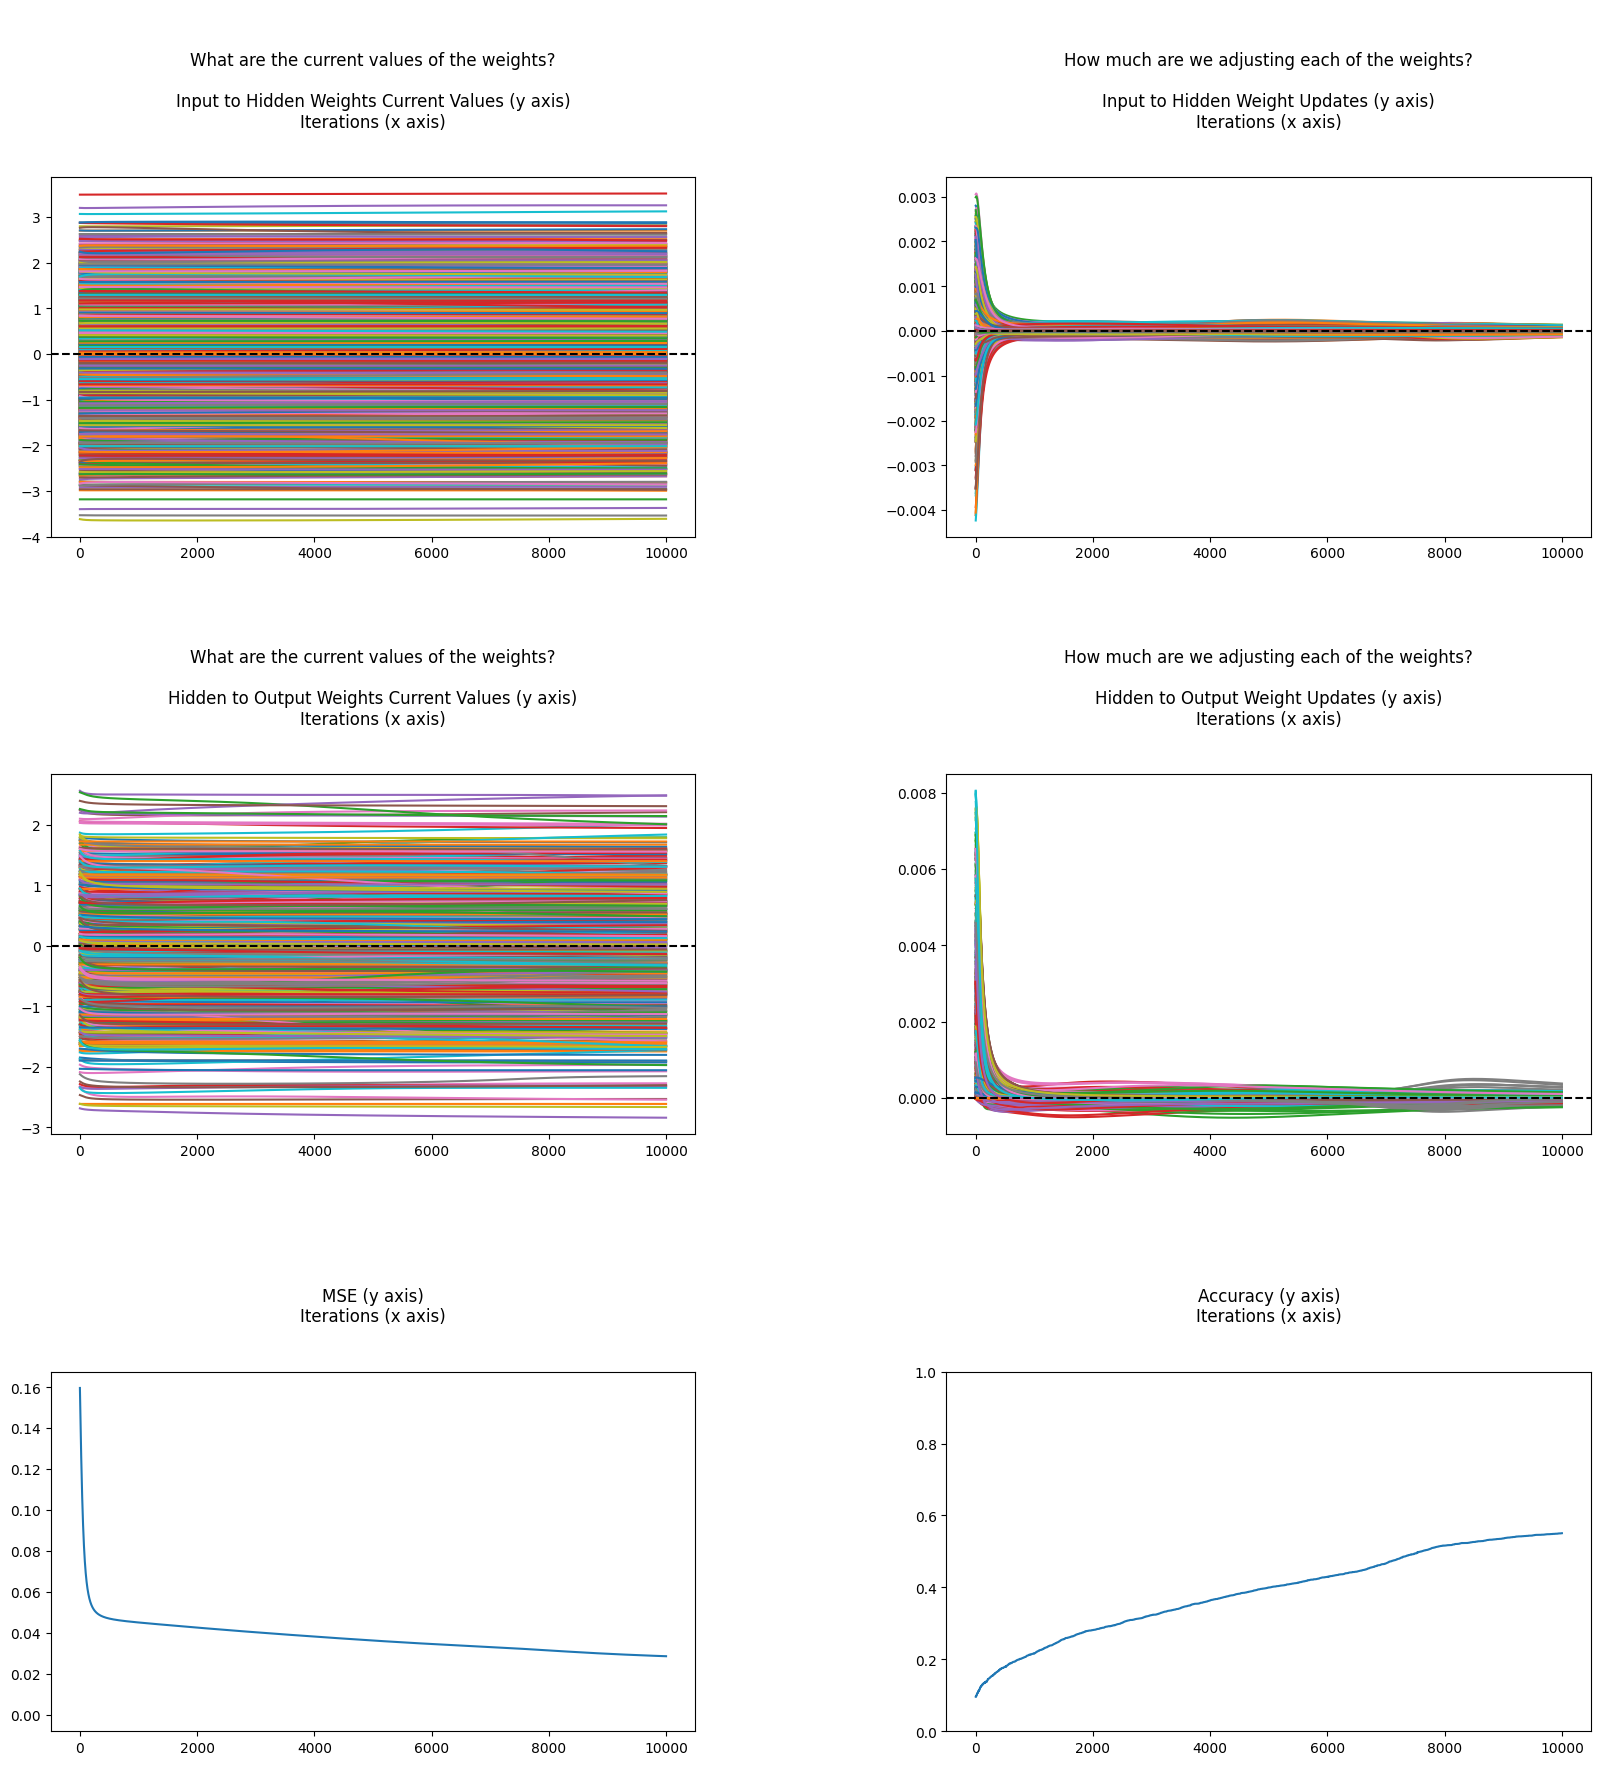

In [41]:
plot_results(mlp_base_02_output['weights_1_full'],
             mlp_base_02_output['weights_1_updates'],
             mlp_base_02_output['weights_2'],
             mlp_base_02_output['weights_2_updates'],
             mlp_base_02_output['scores']
             )

In [42]:
keys_extract = ['final_W1','final_W2']

mlp_base_02_final_wts = {k: mlp_base_02_output[k] for k in keys_extract}

with open('./MLP_Models/mlp_base_02_final_wts.pkl','wb') as f:
    pickle.dump(mlp_base_02_final_wts, f)

<h4> Base Case 3 - No Dropout Layer (Hidden Nodes = 1/2 * # of Input Variables)</h4>

In [43]:
### Seed Storage for testing
# seed_wt_init = 98
# seet_dropout = 11

### Model Name
model_nm = 'mlp_base_03'

### Static Dropout Rate
sdr = 0

N = y_train.size                    
input_size = X_train.shape[1]       
hidden_size = round(X_train.shape[1] * 0.5)                     
output_size = y_train.shape[1]       

### Run Network
mlp_base_03_output = AJMRG_MLP(X_train, y_train, N, input_size, hidden_size, output_size, model_nm, static_drop_out_rate = sdr)


saving initial_mlp_base_03 weights
starting iteration      0 of  10000
starting iteration   1000 of  10000
starting iteration   2000 of  10000
starting iteration   3000 of  10000
starting iteration   4000 of  10000
starting iteration   5000 of  10000
starting iteration   6000 of  10000
starting iteration   7000 of  10000
starting iteration   8000 of  10000
starting iteration   9000 of  10000

saving final_mlp_base_03 weights
complete


In [44]:
### Full Training Accuracy Final using Full Final Training Weights

acc_train, mse_train = nn_runner(X_train, y_train, mlp_base_03_output['final_W1'], mlp_base_03_output['final_W2'])

Final training accuracy: 0.4744
            Final loss: 0.0346


In [45]:
### Testing Accuracy Final using Full Final Training Weights

acc_test, mse_test = nn_runner(X_test, y_test, mlp_base_03_output['final_W1'], mlp_base_03_output['final_W2'])

Final training accuracy: 0.4760
            Final loss: 0.0343


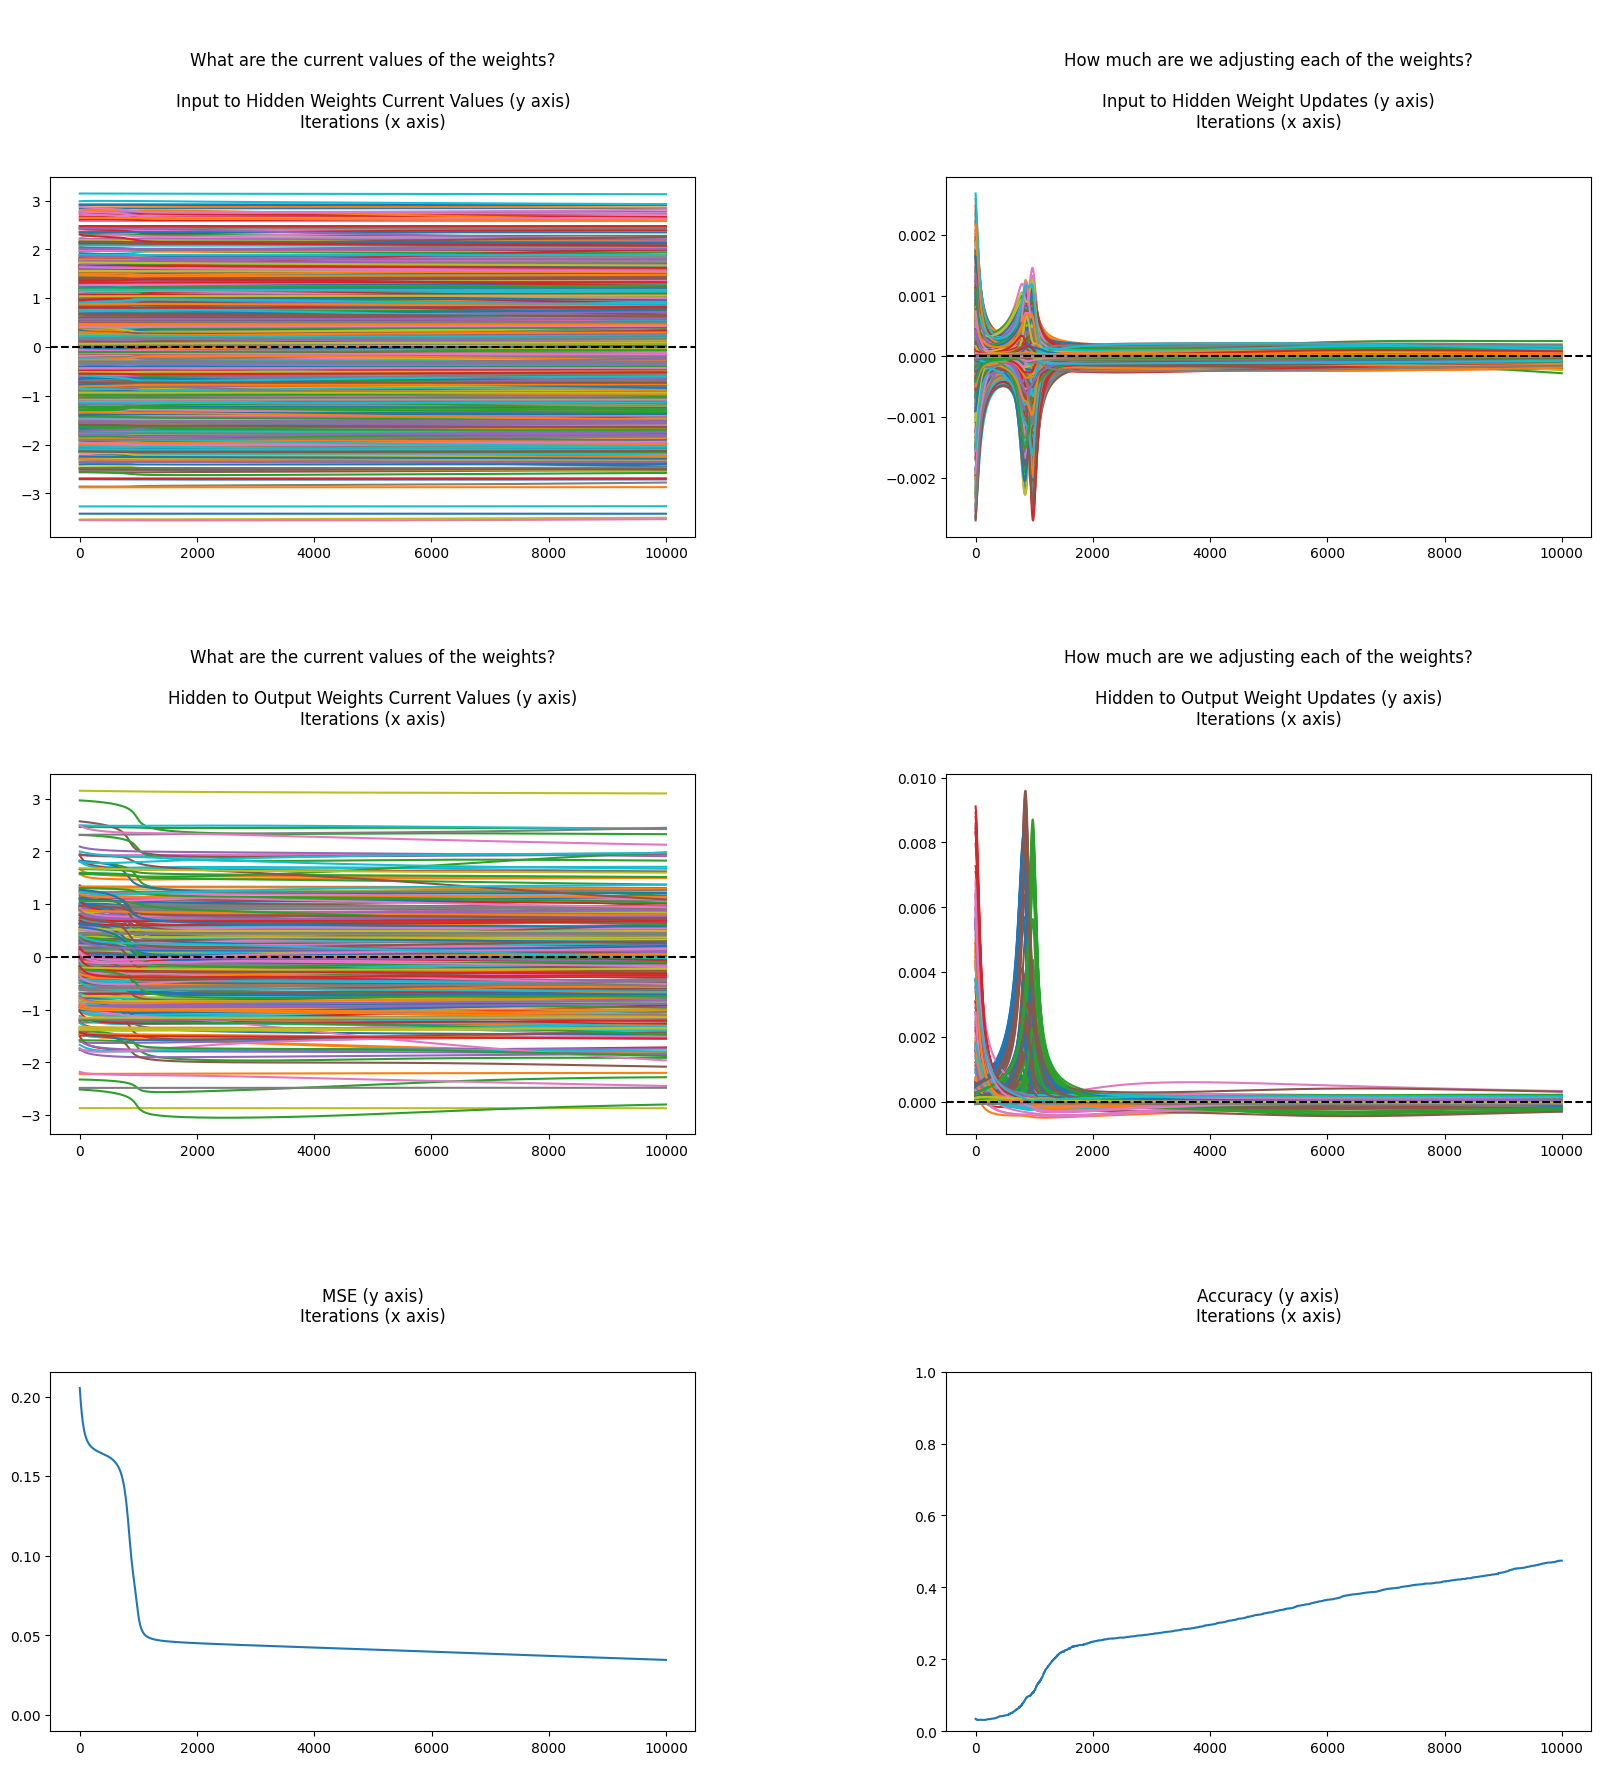

In [46]:
plot_results(mlp_base_03_output['weights_1_full'],
             mlp_base_03_output['weights_1_updates'],
             mlp_base_03_output['weights_2'],
             mlp_base_03_output['weights_2_updates'],
             mlp_base_03_output['scores']
             )

In [47]:
keys_extract = ['final_W1','final_W2']

mlp_base_03_final_wts = {k: mlp_base_03_output[k] for k in keys_extract}

with open('./MLP_Models/mlp_base_03_final_wts.pkl','wb') as f:
    pickle.dump(mlp_base_03_final_wts, f)

#### Static Dropout MLP @ 0.4

<h4> Static Case 1 - Static Dropout Layer (Hidden Nodes = 2 * # of Input Variables)</h4>

In [48]:
### Seed Storage for testing
# seed_wt_init = 98
# seet_dropout = 11

### Model Name
model_nm = 'mlp_static_01'

### Static Dropout Rate
sdr = 0.4

N = y_train.size                    
input_size = X_train.shape[1]       
hidden_size = X_train.shape[1] * 2                     
output_size = y_train.shape[1]       

### Run Network
mlp_static_01_output = AJMRG_MLP(X_train, y_train, N, input_size, hidden_size, output_size, model_nm, static_drop_out_rate = sdr)


saving initial_mlp_static_01 weights
starting iteration      0 of  10000
starting iteration   1000 of  10000
starting iteration   2000 of  10000
starting iteration   3000 of  10000
starting iteration   4000 of  10000
starting iteration   5000 of  10000
starting iteration   6000 of  10000
starting iteration   7000 of  10000
starting iteration   8000 of  10000
starting iteration   9000 of  10000

saving final_mlp_static_01 weights
complete


In [49]:
### Full Training Accuracy Final using Full Final Training Weights

acc_train, mse_train = nn_runner(X_train, y_train, mlp_static_01_output['final_W1'], mlp_static_01_output['final_W2'])

Final training accuracy: 0.0992
            Final loss: 0.1261


In [50]:
### Testing Accuracy Final using Full Final Training Weights

acc_test, mse_test = nn_runner(X_test, y_test, mlp_static_01_output['final_W1'], mlp_static_01_output['final_W2'])

Final training accuracy: 0.0988
            Final loss: 0.1262


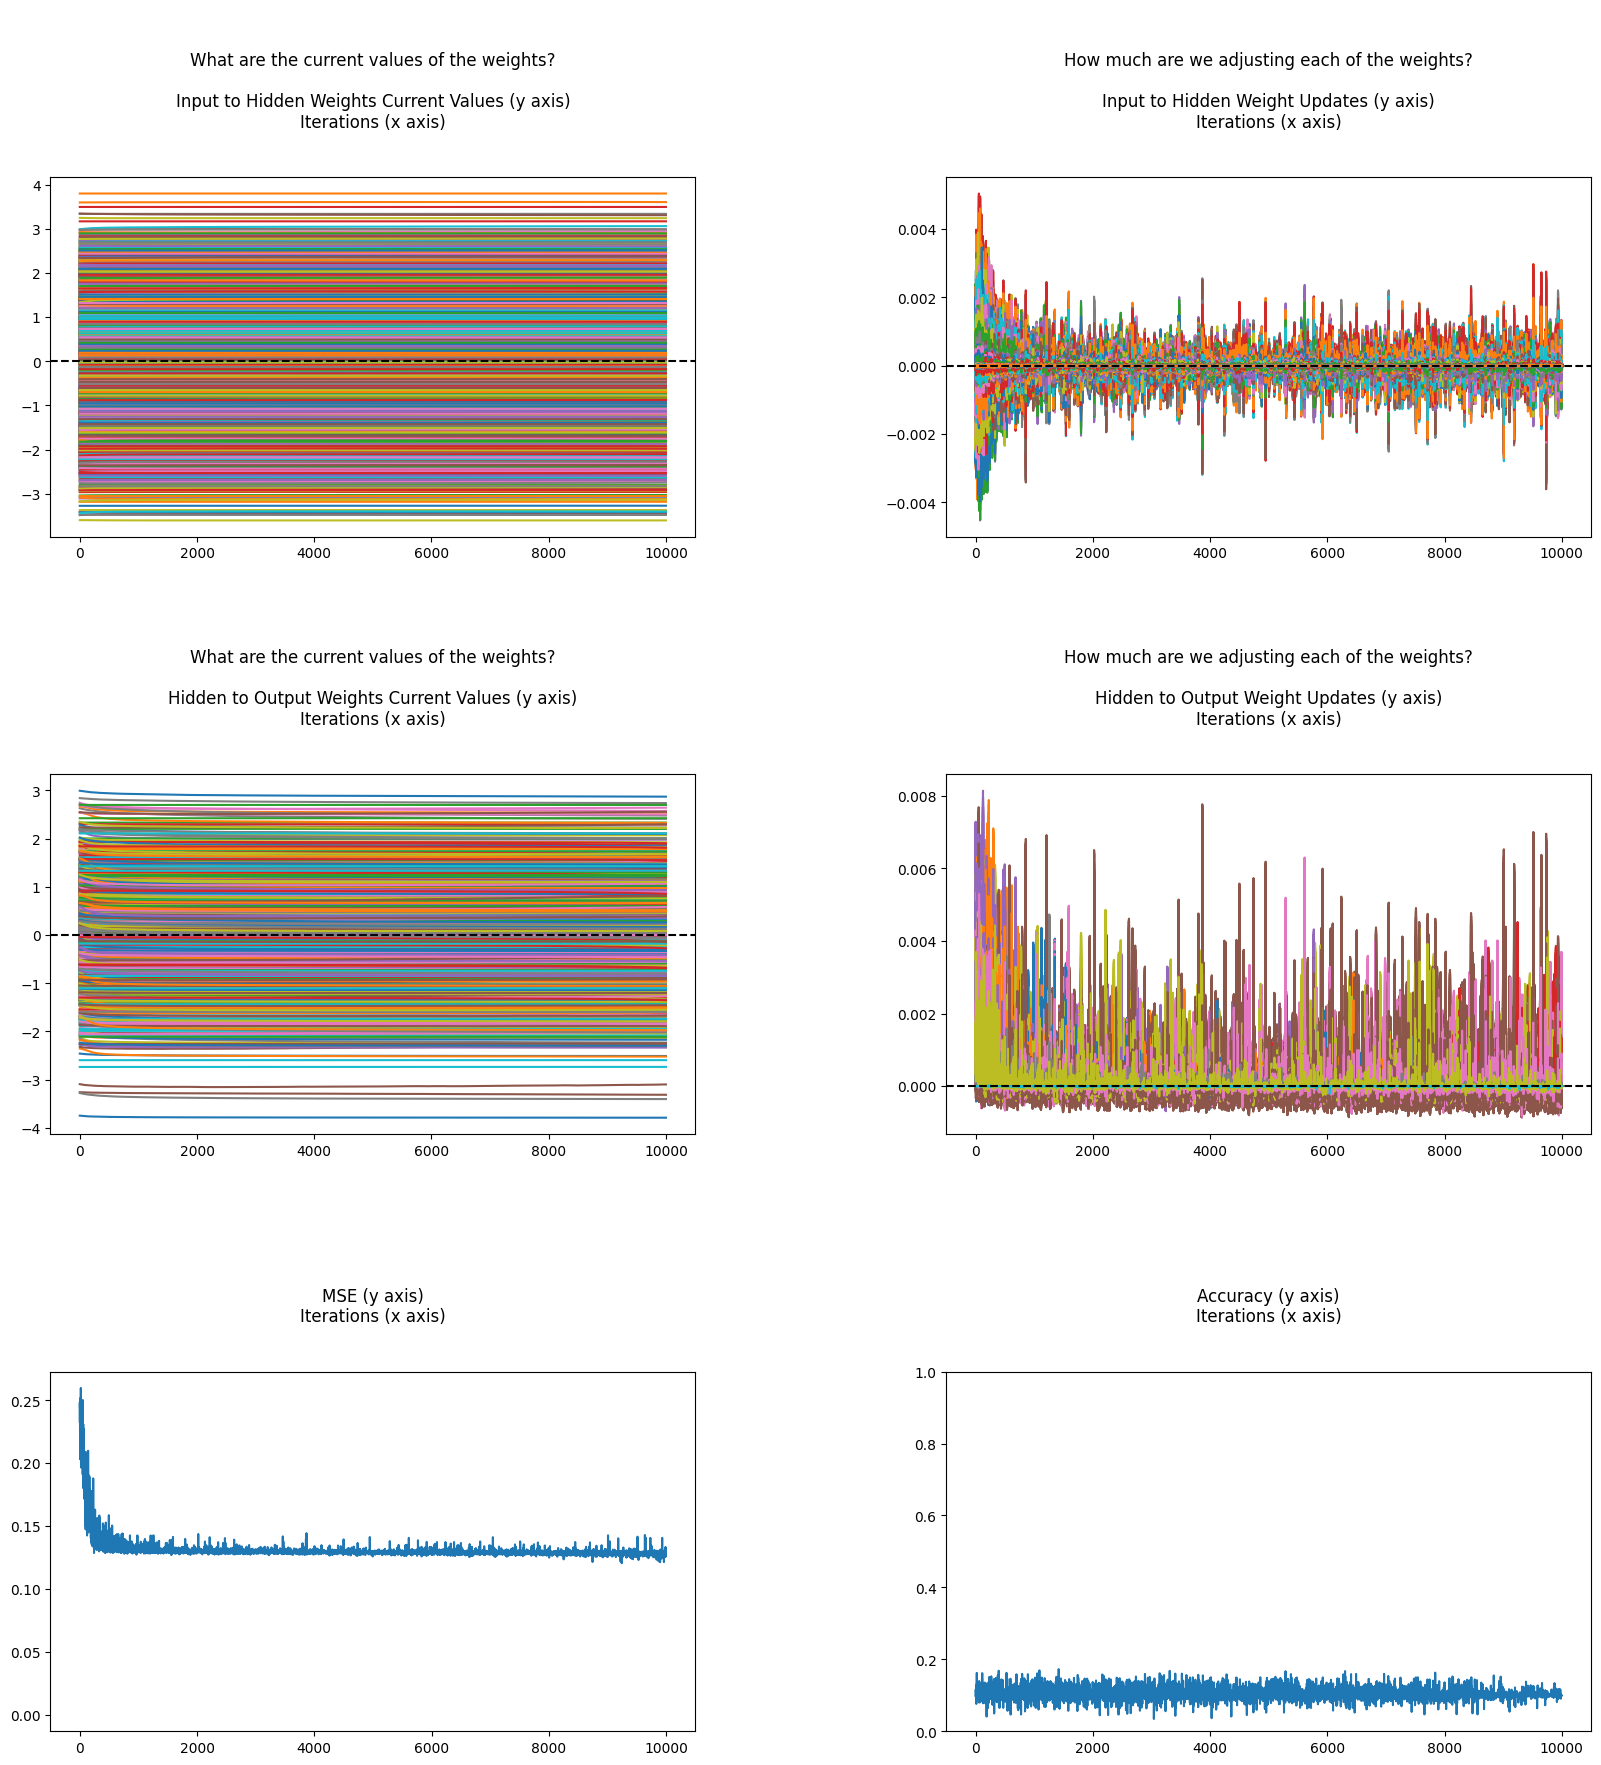

In [51]:
plot_results(mlp_static_01_output['weights_1_full'],
             mlp_static_01_output['weights_1_updates'],
             mlp_static_01_output['weights_2'],
             mlp_static_01_output['weights_2_updates'],
             mlp_static_01_output['scores']
             )

In [52]:
keys_extract = ['final_W1','final_W2']

mlp_static_01_final_wts = {k: mlp_static_01_output[k] for k in keys_extract}

with open('./MLP_Models/mlp_static_01_final_wts.pkl','wb') as f:
    pickle.dump(mlp_static_01_final_wts, f)

<h4> Static Case 2 - Static Dropout Layer (Hidden Nodes = 1/2 * # of Input Variables)</h4>

In [53]:
### Seed Storage for testing
# seed_wt_init = 98
# seet_dropout = 11

### Model Name
model_nm = 'mlp_static_02'

### Static Dropout Rate
sdr = 0.4

N = y_train.size                    
input_size = X_train.shape[1]       
hidden_size = round(X_train.shape[1] * 0.5)                      
output_size = y_train.shape[1]       

### Run Network
mlp_static_02_output = AJMRG_MLP(X_train, y_train, N, input_size, hidden_size, output_size, model_nm, static_drop_out_rate = sdr)


saving initial_mlp_static_02 weights
starting iteration      0 of  10000
starting iteration   1000 of  10000
starting iteration   2000 of  10000
starting iteration   3000 of  10000
starting iteration   4000 of  10000
starting iteration   5000 of  10000
starting iteration   6000 of  10000
starting iteration   7000 of  10000
starting iteration   8000 of  10000
starting iteration   9000 of  10000

saving final_mlp_static_02 weights
complete


In [54]:
### Full Training Accuracy Final using Full Final Training Weights

acc_train, mse_train = nn_runner(X_train, y_train, mlp_static_02_output['final_W1'], mlp_static_02_output['final_W2'])

Final training accuracy: 0.3027
            Final loss: 0.0406


In [55]:
### Testing Accuracy Final using Full Final Training Weights

acc_test, mse_test = nn_runner(X_test, y_test, mlp_static_02_output['final_W1'], mlp_static_02_output['final_W2'])

Final training accuracy: 0.3096
            Final loss: 0.0406


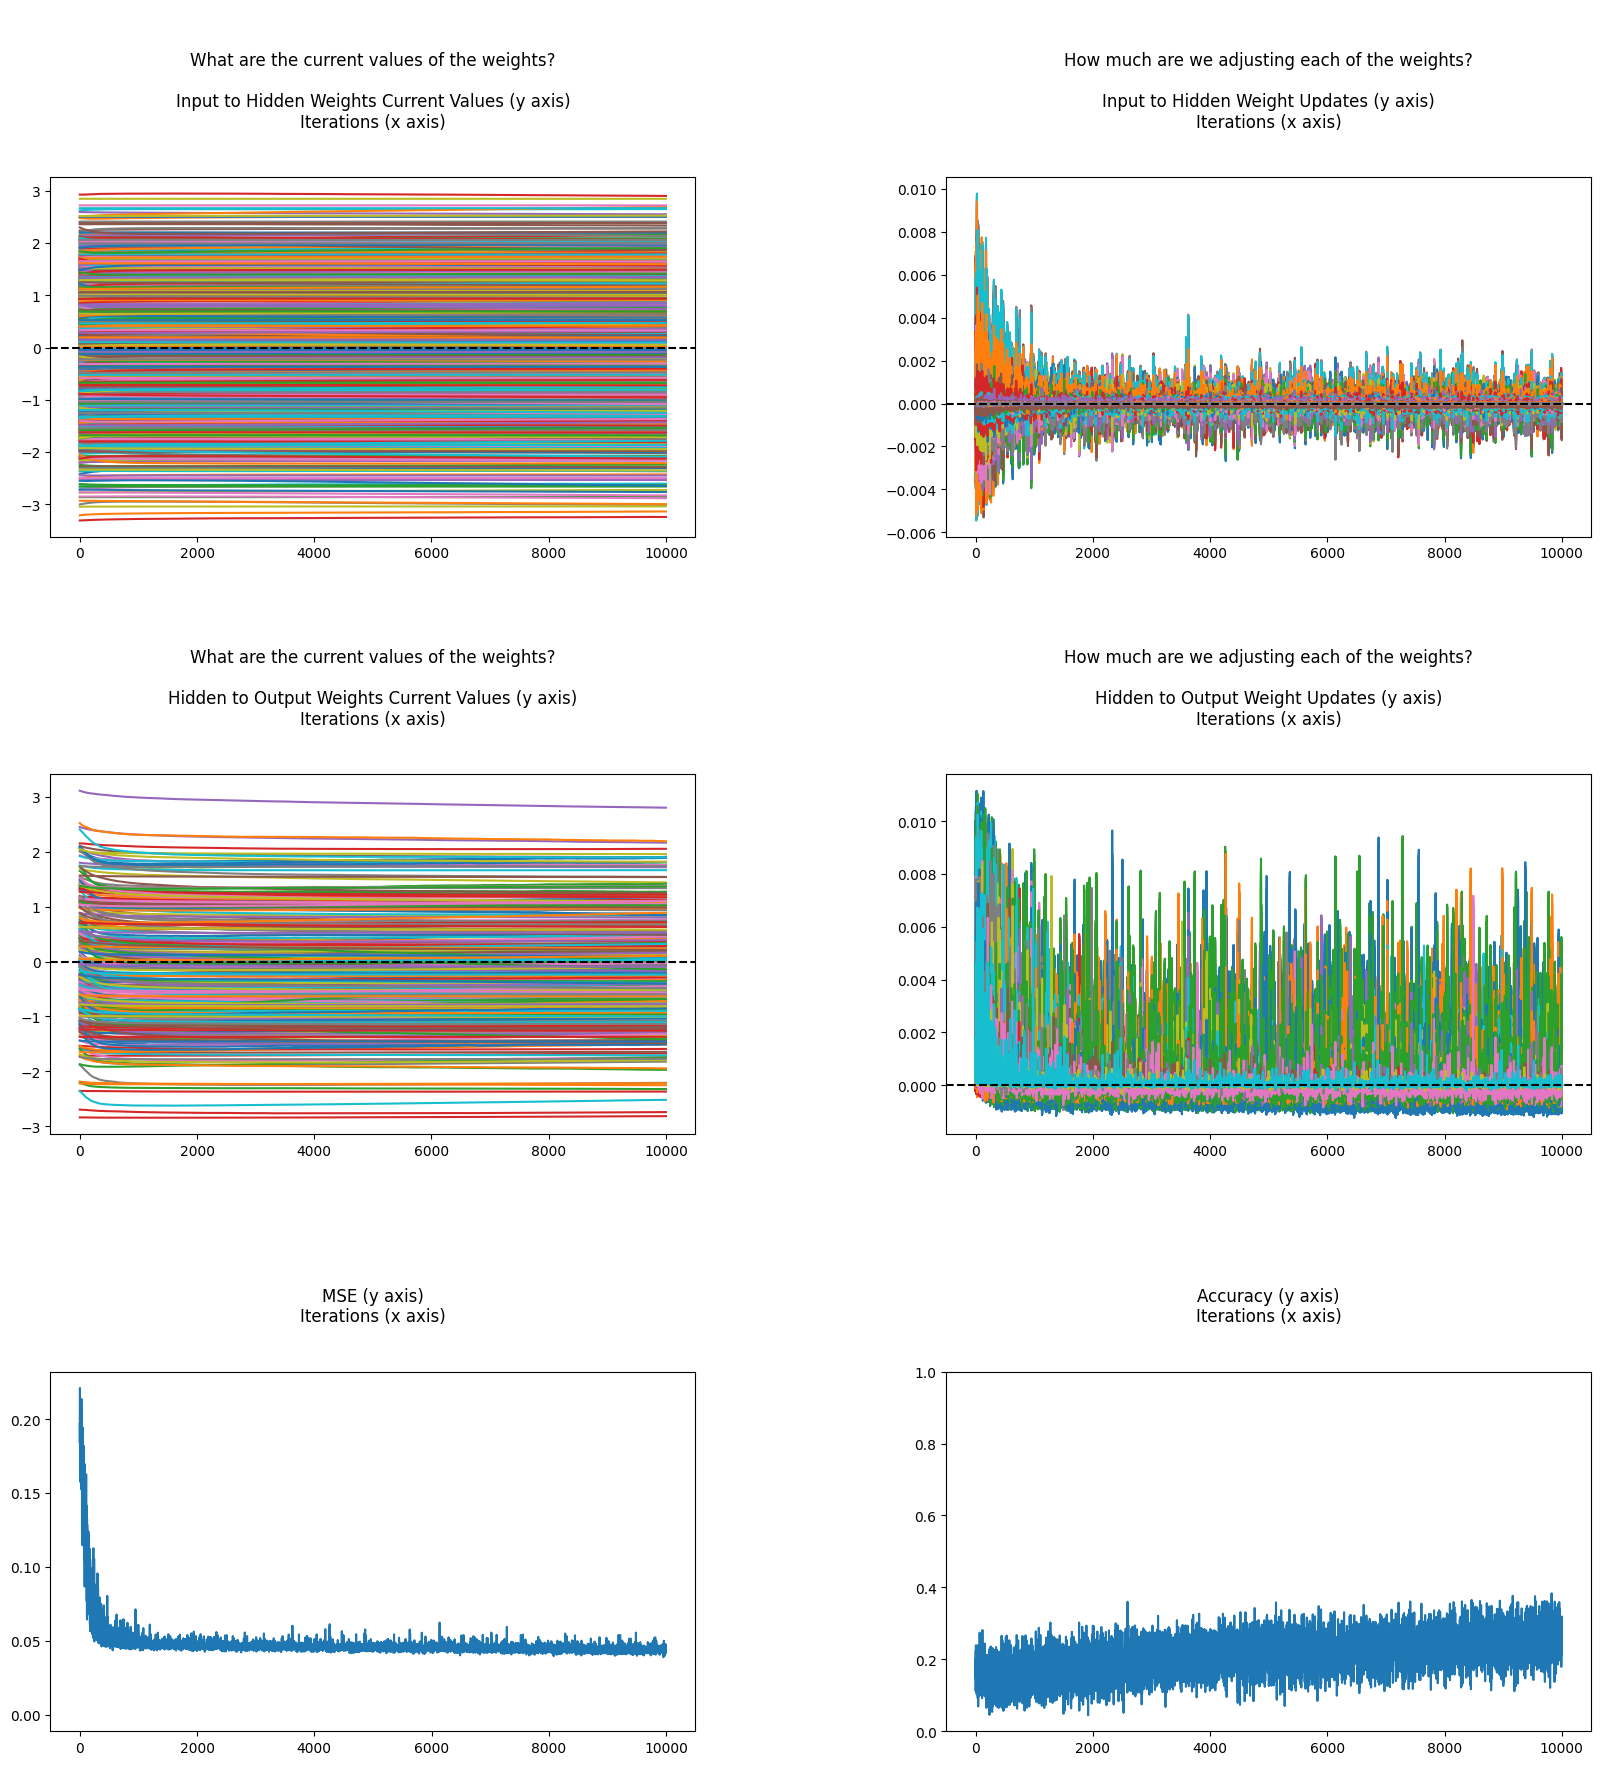

In [56]:
plot_results(mlp_static_02_output['weights_1_full'],
             mlp_static_02_output['weights_1_updates'],
             mlp_static_02_output['weights_2'],
             mlp_static_02_output['weights_2_updates'],
             mlp_static_02_output['scores']
             )

In [57]:
keys_extract = ['final_W1','final_W2']

mlp_static_02_final_wts = {k: mlp_static_02_output[k] for k in keys_extract}

with open('./MLP_Models/mlp_static_02_final_wts.pkl','wb') as f:
    pickle.dump(mlp_static_02_final_wts, f)

<h4> Static Case 3 - Static Dropout Layer (Hidden Nodes = # of Input Variables)</h4>

In [58]:
### Seed Storage for testing
# seed_wt_init = 98
# seet_dropout = 11

### Model Name
model_nm = 'mlp_static_03'

### Static Dropout Rate
sdr = 0.4

N = y_train.size                    
input_size = X_train.shape[1]       
hidden_size = X_train.shape[1]                    
output_size = y_train.shape[1]       

### Run Network
mlp_static_03_output = AJMRG_MLP(X_train, y_train, N, input_size, hidden_size, output_size, model_nm, static_drop_out_rate = sdr)


saving initial_mlp_static_03 weights
starting iteration      0 of  10000
starting iteration   1000 of  10000
starting iteration   2000 of  10000
starting iteration   3000 of  10000
starting iteration   4000 of  10000
starting iteration   5000 of  10000
starting iteration   6000 of  10000
starting iteration   7000 of  10000
starting iteration   8000 of  10000
starting iteration   9000 of  10000

saving final_mlp_static_03 weights
complete


In [59]:
### Full Training Accuracy Final using Full Final Training Weights

acc_train, mse_train = nn_runner(X_train, y_train, mlp_static_03_output['final_W1'], mlp_static_03_output['final_W2'])

Final training accuracy: 0.2647
            Final loss: 0.0430


In [60]:
### Testing Accuracy Final using Full Final Training Weights

acc_test, mse_test = nn_runner(X_test, y_test, mlp_static_03_output['final_W1'], mlp_static_03_output['final_W2'])

Final training accuracy: 0.2625
            Final loss: 0.0429


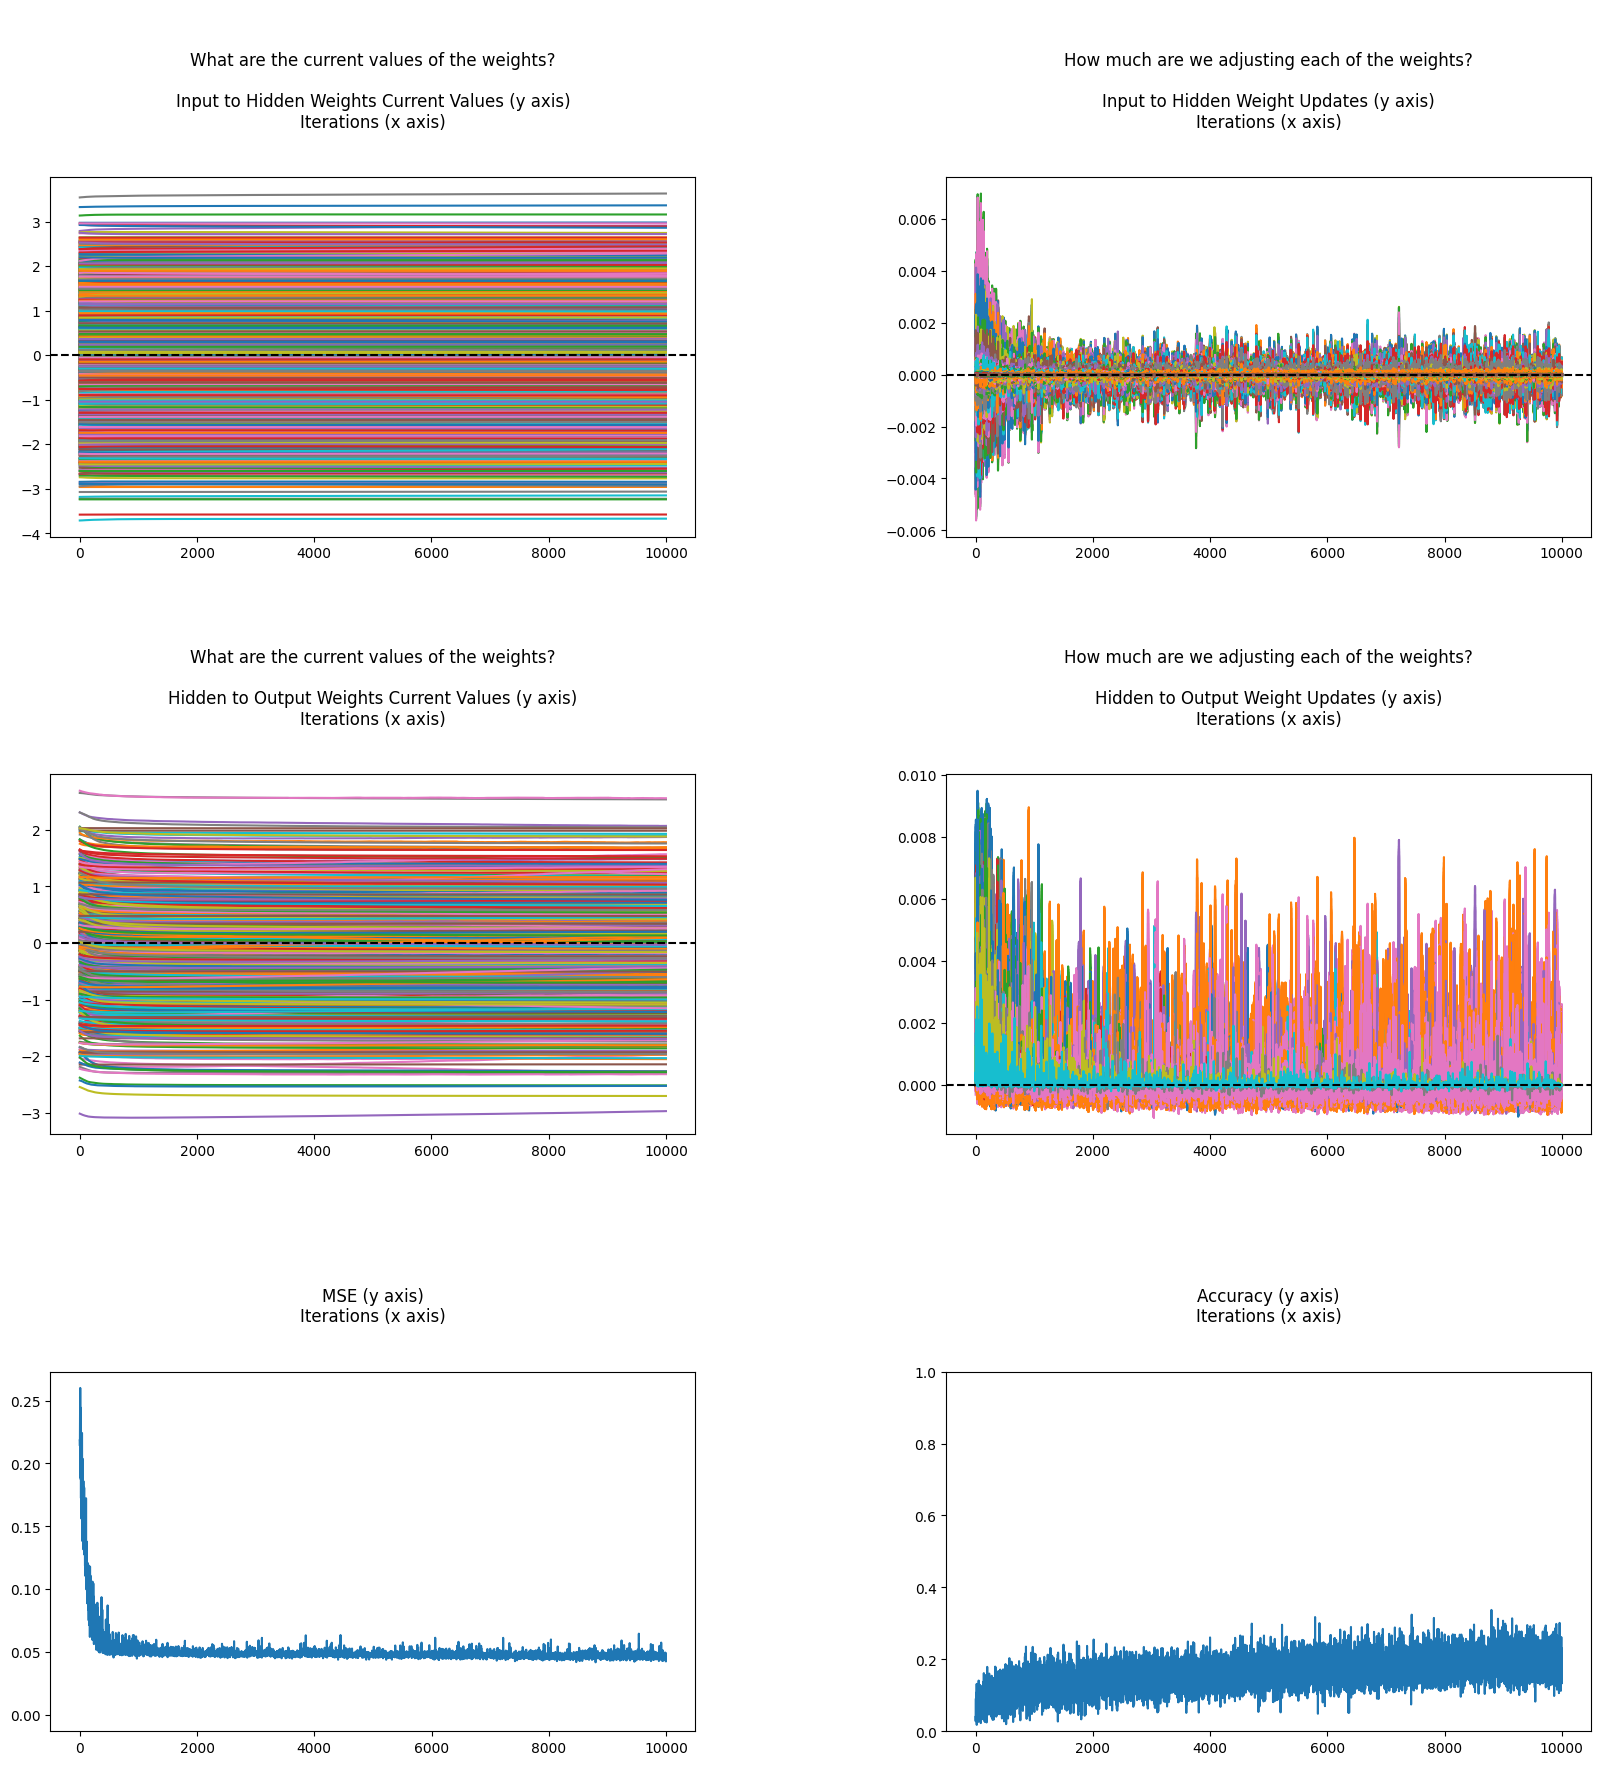

In [61]:
plot_results(mlp_static_03_output['weights_1_full'],
             mlp_static_03_output['weights_1_updates'],
             mlp_static_03_output['weights_2'],
             mlp_static_03_output['weights_2_updates'],
             mlp_static_03_output['scores']
             )

In [62]:
keys_extract = ['final_W1','final_W2']

mlp_static_03_final_wts = {k: mlp_static_03_output[k] for k in keys_extract}

with open('./MLP_Models/mlp_static_03_final_wts.pkl','wb') as f:
    pickle.dump(mlp_static_03_final_wts, f)

#### Dynamic Dropout MLP

<h4> Dynamic Case 1 - Dynamic Dropout Layer (Hidden Nodes = 2 * # of Input Variables)</h4>

In [208]:
### Seed Storage for testing
# seed_wt_init = 98
# seet_dropout = 11

### Model Name
model_nm = 'mlp_dynamic_01'

### Static Dropout Rate
sdr = None

N = y_train.size                    
input_size = X_train.shape[1]       
hidden_size = X_train.shape[1] * 2                     
output_size = y_train.shape[1]       

### Run Network
mlp_dynamic_01_output = AJMRG_MLP(X_train, y_train, N, input_size, hidden_size, output_size, model_nm, static_drop_out_rate = sdr)


saving initial_mlp_dynamic_01 weights
starting iteration      0 of  10000
starting iteration   1000 of  10000
starting iteration   2000 of  10000
starting iteration   3000 of  10000
starting iteration   4000 of  10000
starting iteration   5000 of  10000
starting iteration   6000 of  10000
starting iteration   7000 of  10000
starting iteration   8000 of  10000
starting iteration   9000 of  10000

saving final_mlp_dynamic_01 weights
complete


In [209]:
### Full Training Accuracy Final using Full Final Training Weights

acc_train, mse_train = nn_runner(X_train, y_train, mlp_dynamic_01_output['final_W1'], mlp_dynamic_01_output['final_W2'])

Final training accuracy: 0.1884
            Final loss: 0.0496


In [210]:
### Testing Accuracy Final using Full Final Training Weights

acc_test, mse_test = nn_runner(X_test, y_test, mlp_dynamic_01_output['final_W1'], mlp_dynamic_01_output['final_W2'])

Final training accuracy: 0.1957
            Final loss: 0.0497


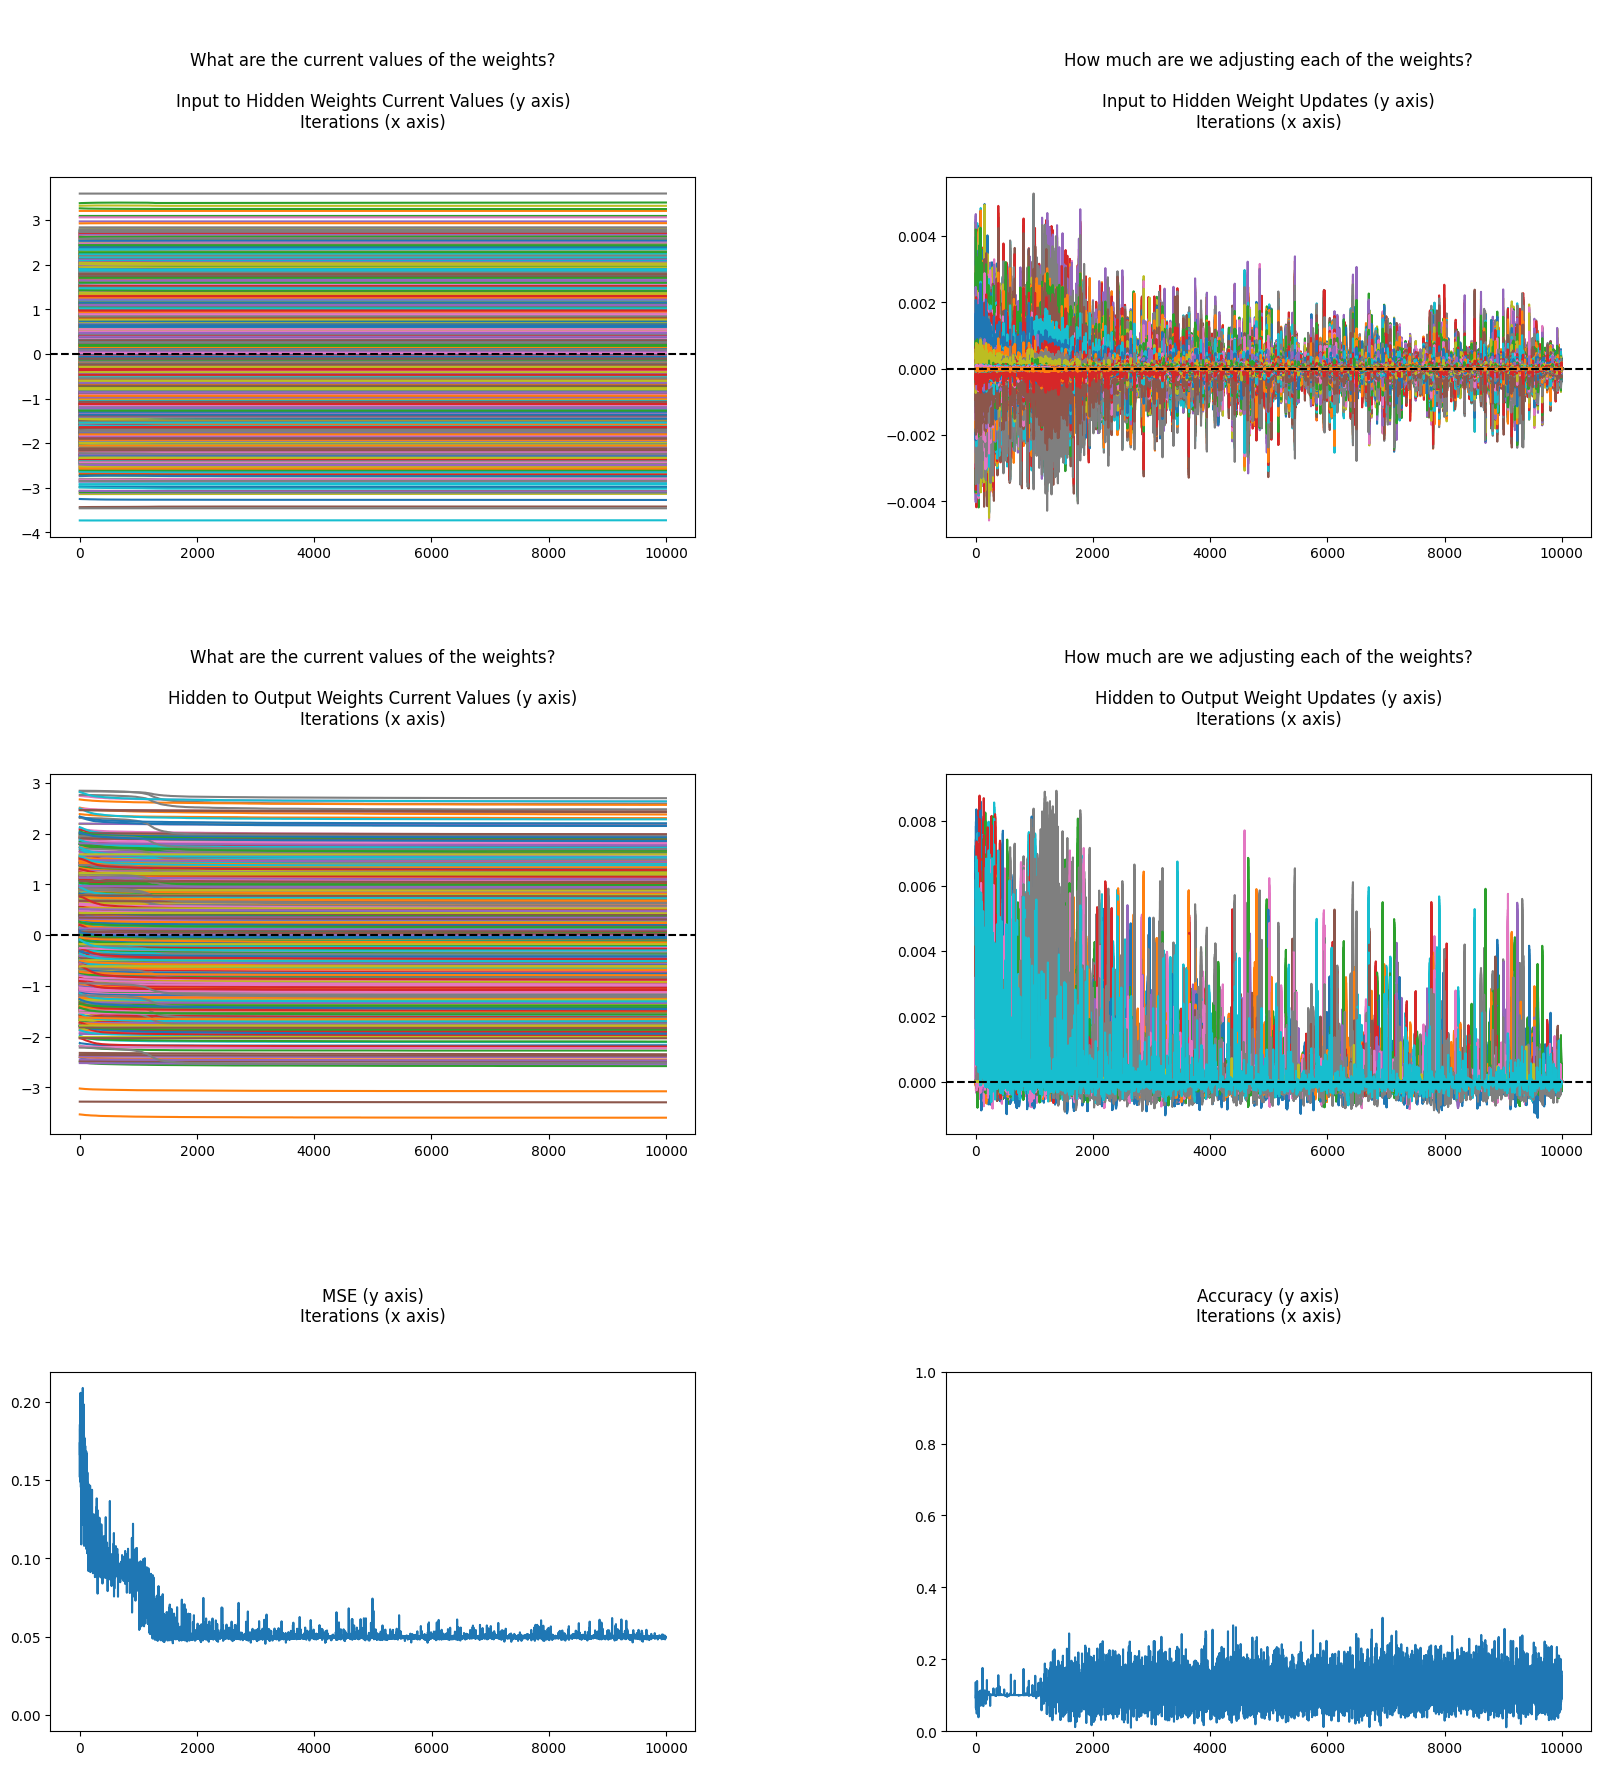

In [211]:
plot_results(mlp_dynamic_01_output['weights_1_full'],
             mlp_dynamic_01_output['weights_1_updates'],
             mlp_dynamic_01_output['weights_2'],
             mlp_dynamic_01_output['weights_2_updates'],
             mlp_dynamic_01_output['scores']
             )

In [212]:
keys_extract = ['final_W1','final_W2']

mlp_dynamic_01_final_wts = {k: mlp_dynamic_01_output[k] for k in keys_extract}

with open('./MLP_Models/mlp_dynamic_01_final_wts.pkl','wb') as f:
    pickle.dump(mlp_dynamic_01_final_wts, f)

<h4> Dynamic Case 2 - Dynamic Dropout Layer (Hidden Nodes = 1/2 * # of Input Variables)</h4>

In [214]:
### Seed Storage for testing
# seed_wt_init = 98
# seet_dropout = 11

### Model Name
model_nm = 'mlp_dynamic_02'

### Static Dropout Rate
sdr = None

N = y_train.size                    
input_size = X_train.shape[1]       
hidden_size = round(X_train.shape[1] * 0.5)                    
output_size = y_train.shape[1]       

### Run Network
mlp_dynamic_02_output = AJMRG_MLP(X_train, y_train, N, input_size, hidden_size, output_size, model_nm, static_drop_out_rate = sdr)


saving initial_mlp_dynamic_02 weights
starting iteration      0 of  10000
starting iteration   1000 of  10000
starting iteration   2000 of  10000
starting iteration   3000 of  10000
starting iteration   4000 of  10000
starting iteration   5000 of  10000
starting iteration   6000 of  10000
starting iteration   7000 of  10000
starting iteration   8000 of  10000
starting iteration   9000 of  10000

saving final_mlp_dynamic_02 weights
complete


In [215]:
### Full Training Accuracy Final using Full Final Training Weights

acc_train, mse_train = nn_runner(X_train, y_train, mlp_dynamic_02_output['final_W1'], mlp_dynamic_02_output['final_W2'])

Final training accuracy: 0.1468
            Final loss: 0.0482


In [216]:
### Testing Accuracy Final using Full Final Training Weights

acc_test, mse_test = nn_runner(X_test, y_test, mlp_dynamic_02_output['final_W1'], mlp_dynamic_02_output['final_W2'])

Final training accuracy: 0.1459
            Final loss: 0.0481


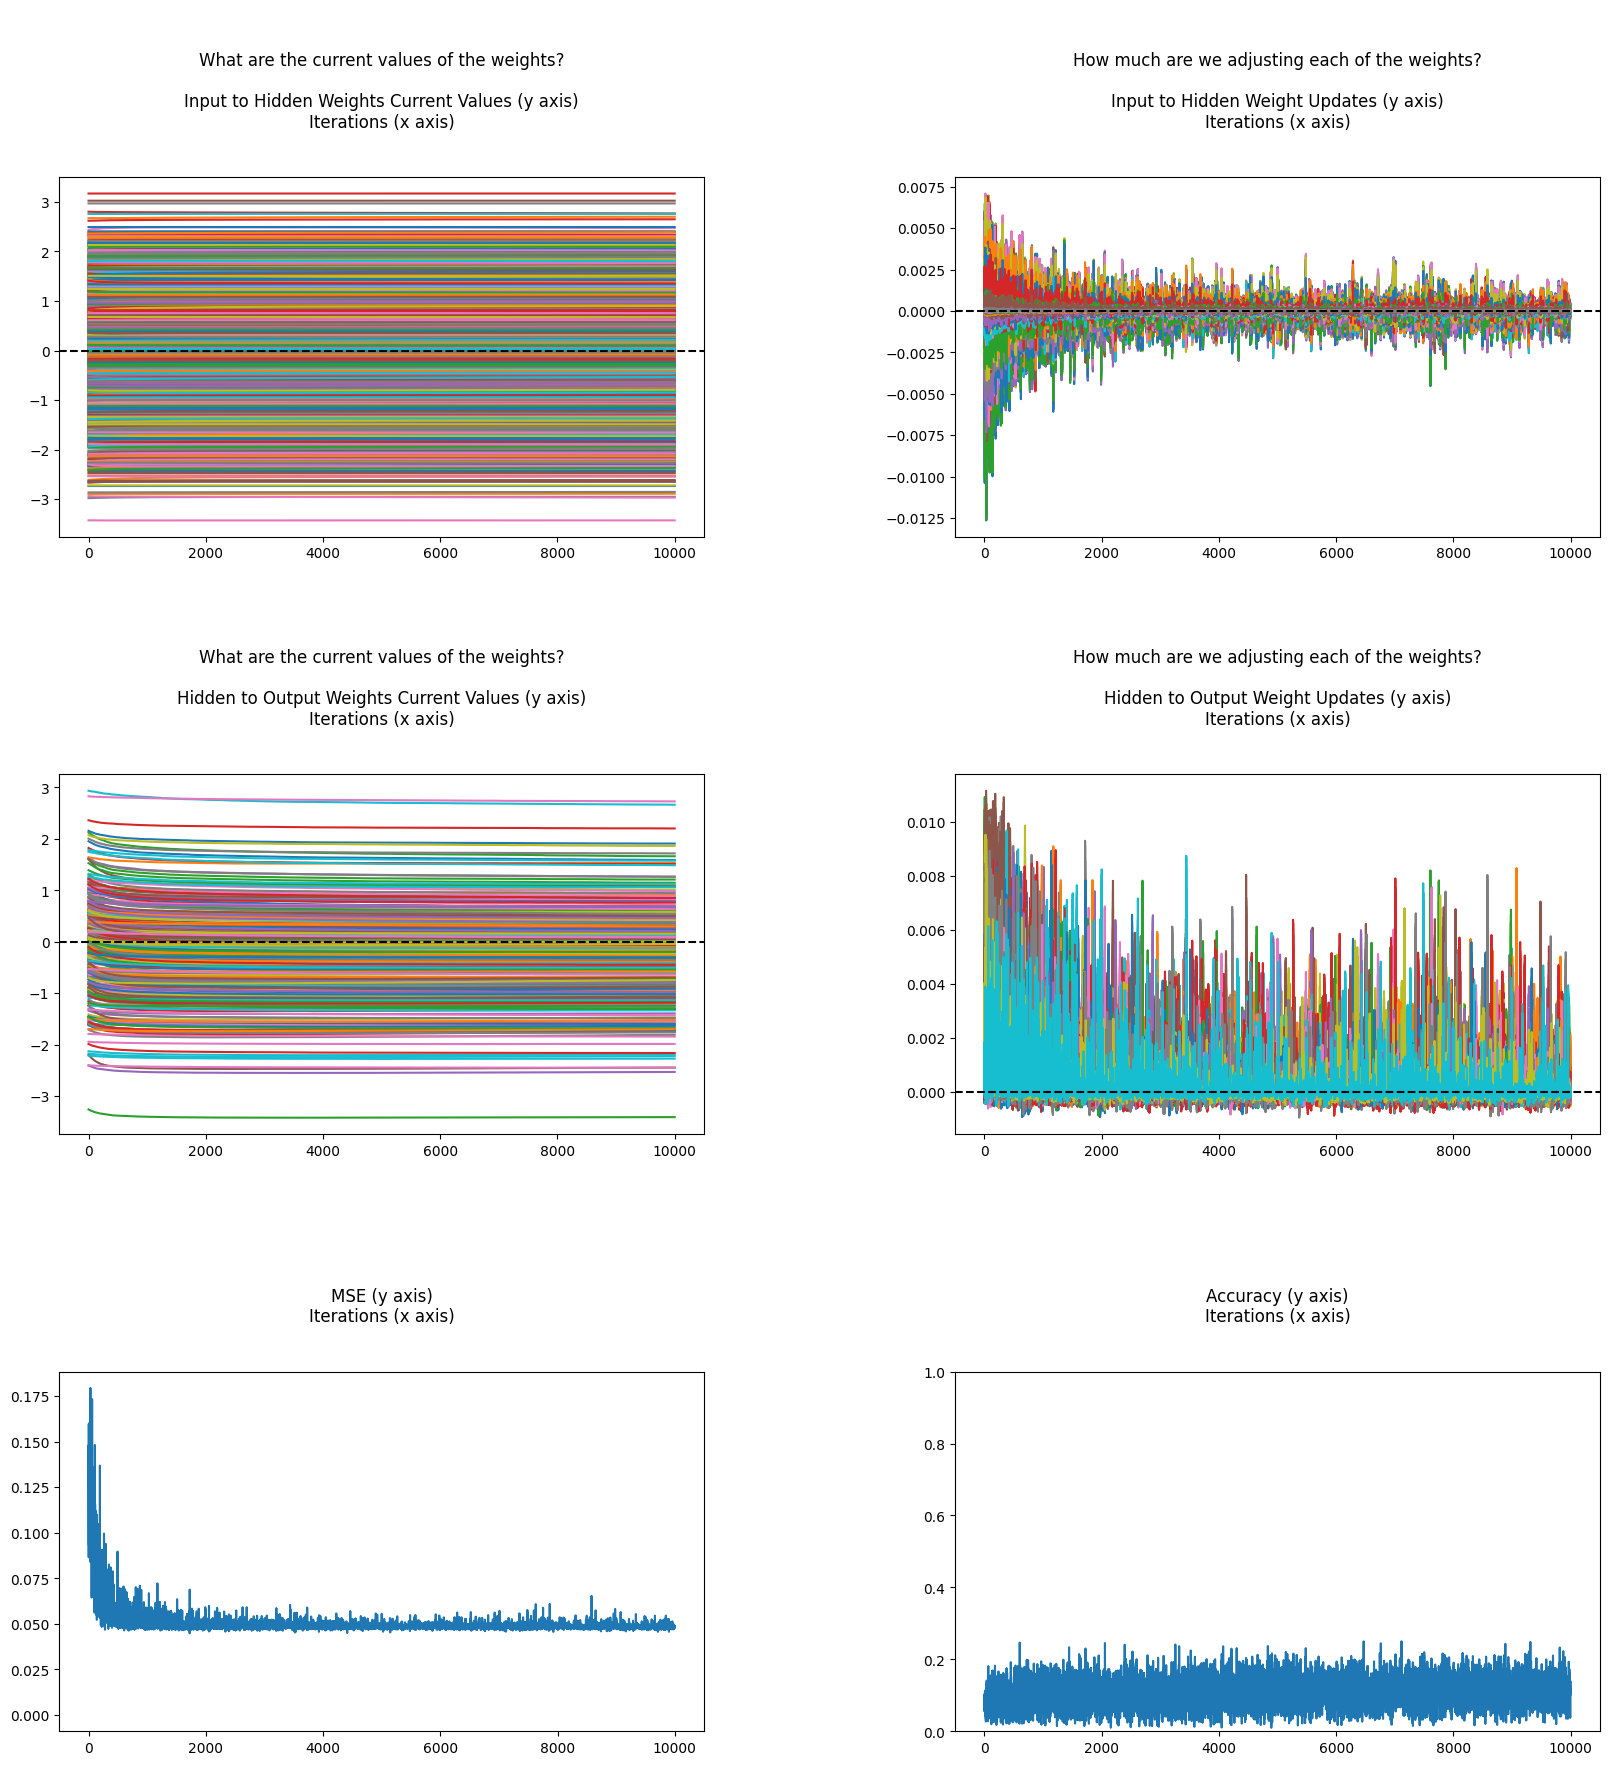

In [217]:
plot_results(mlp_dynamic_02_output['weights_1_full'],
             mlp_dynamic_02_output['weights_1_updates'],
             mlp_dynamic_02_output['weights_2'],
             mlp_dynamic_02_output['weights_2_updates'],
             mlp_dynamic_02_output['scores']
             )

In [218]:
keys_extract = ['final_W1','final_W2']

mlp_dynamic_02_final_wts = {k: mlp_dynamic_02_output[k] for k in keys_extract}

with open('./MLP_Models/mlp_dynamic_02_final_wts.pkl','wb') as f:
    pickle.dump(mlp_dynamic_02_final_wts, f)

<h4> Dynamic Case 3 - Dynamic Dropout Layer (Hidden Nodes = # of Input Variables)</h4>

In [219]:
### Seed Storage for testing
# seed_wt_init = 98
# seet_dropout = 11

### Model Name
model_nm = 'mlp_dynamic_03'

### Static Dropout Rate
sdr = None

N = y_train.size                    
input_size = X_train.shape[1]       
hidden_size = X_train.shape[1]                    
output_size = y_train.shape[1]       

### Run Network
mlp_dynamic_03_output = AJMRG_MLP(X_train, y_train, N, input_size, hidden_size, output_size, model_nm, static_drop_out_rate = sdr)


saving initial_mlp_dynamic_03 weights
starting iteration      0 of  10000
starting iteration   1000 of  10000
starting iteration   2000 of  10000
starting iteration   3000 of  10000
starting iteration   4000 of  10000
starting iteration   5000 of  10000
starting iteration   6000 of  10000
starting iteration   7000 of  10000
starting iteration   8000 of  10000
starting iteration   9000 of  10000

saving final_mlp_dynamic_03 weights
complete


In [220]:
### Full Training Accuracy Final using Full Final Training Weights

acc_train, mse_train = nn_runner(X_train, y_train, mlp_dynamic_03_output['final_W1'], mlp_dynamic_03_output['final_W2'])

Final training accuracy: 0.0983
            Final loss: 0.0493


In [221]:
### Testing Accuracy Final using Full Final Training Weights

acc_test, mse_test = nn_runner(X_test, y_test, mlp_dynamic_03_output['final_W1'], mlp_dynamic_03_output['final_W2'])

Final training accuracy: 0.1041
            Final loss: 0.0494


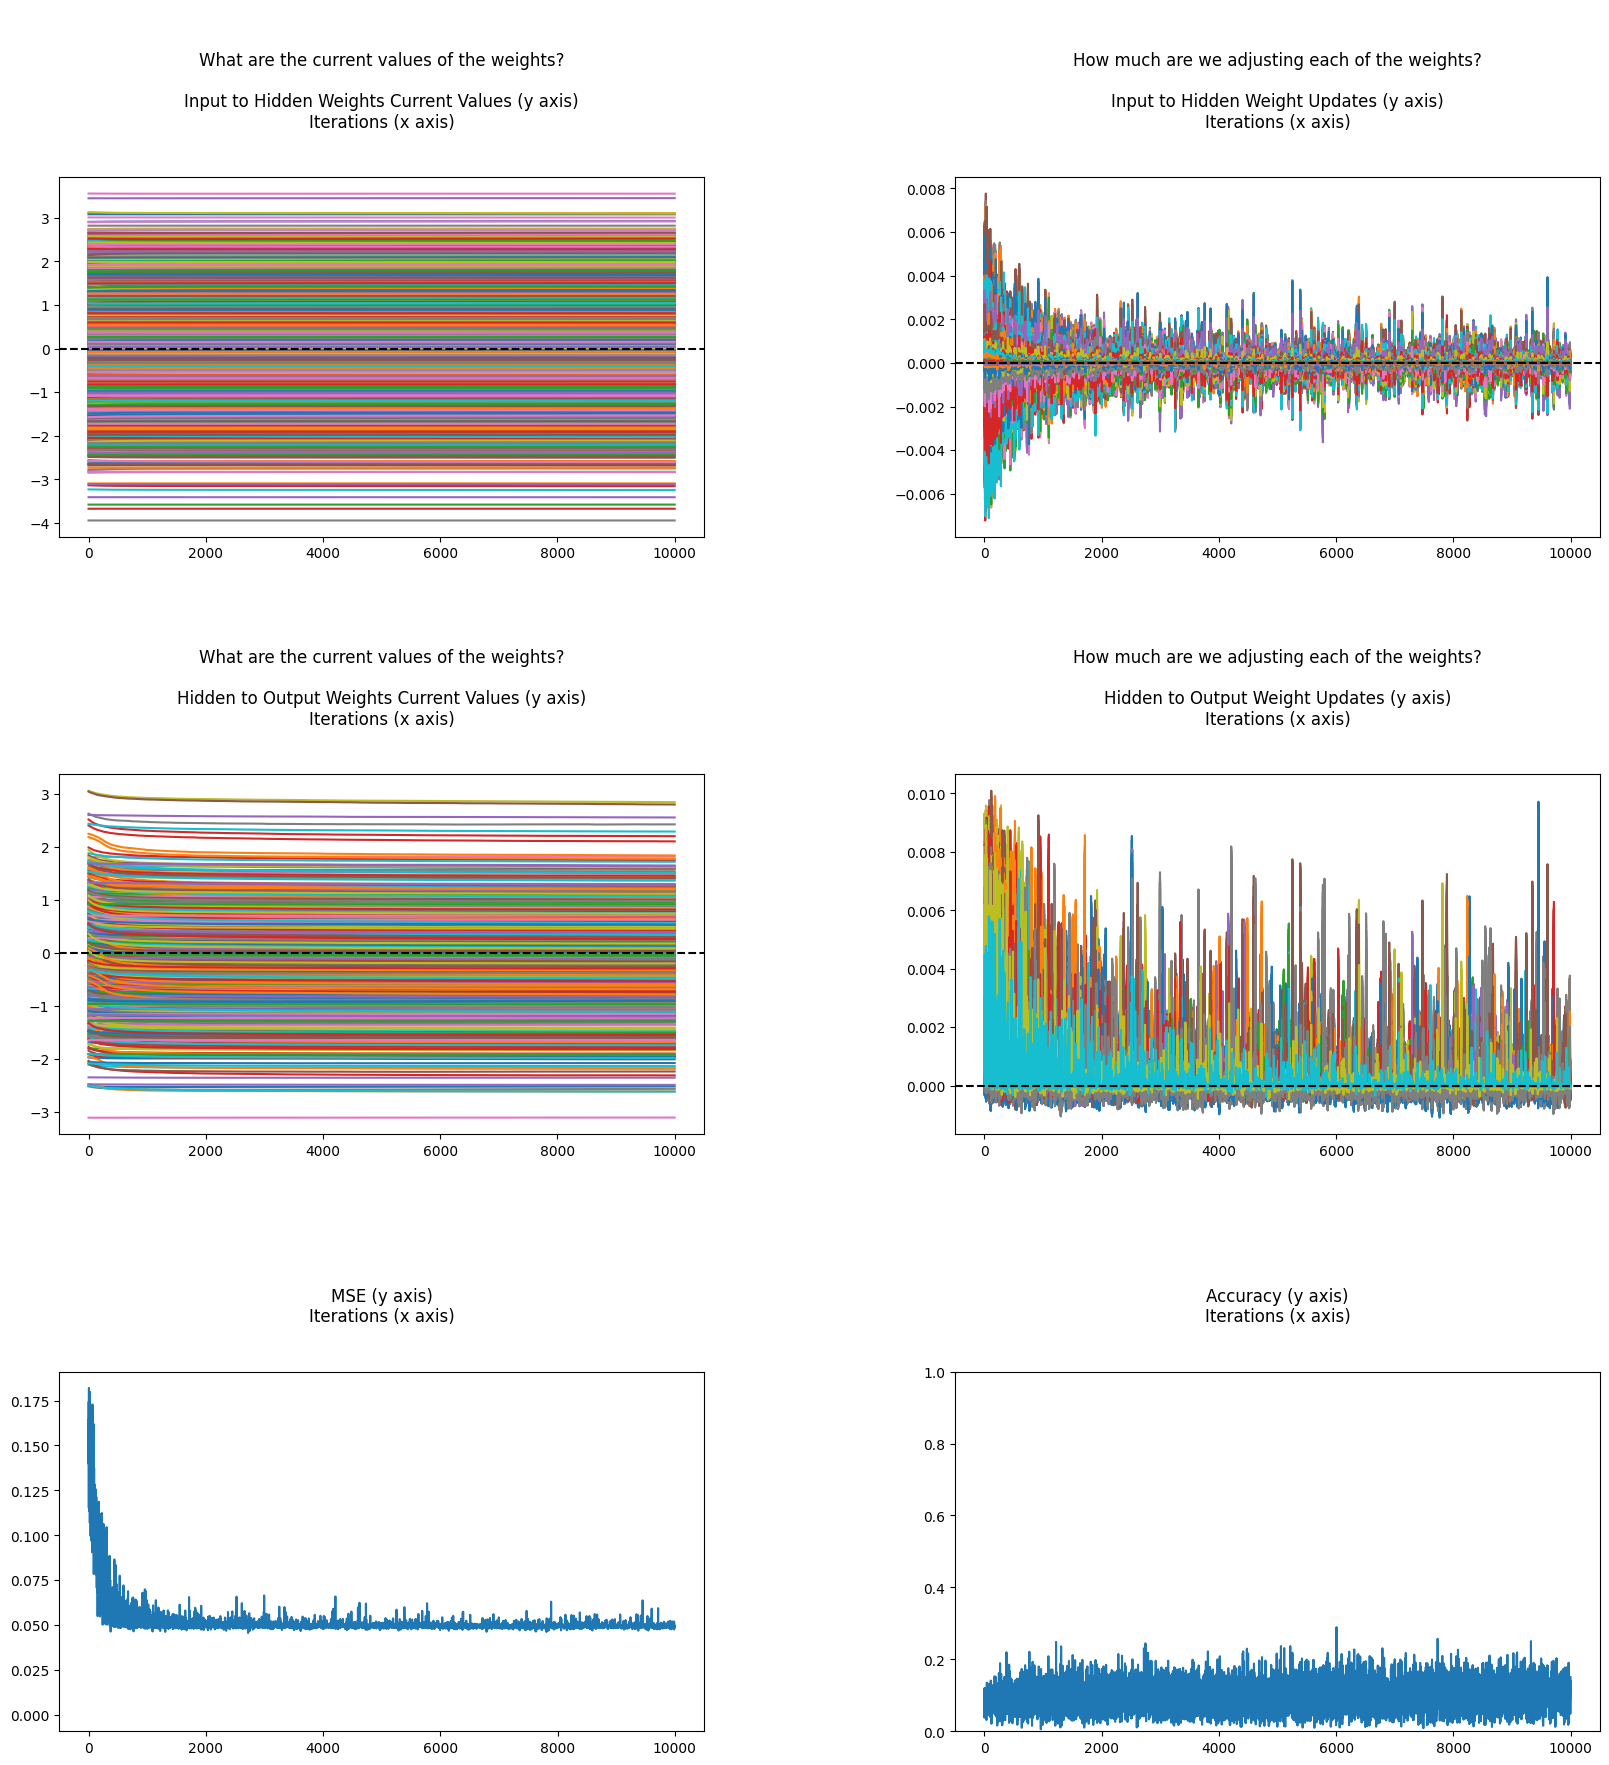

In [222]:
plot_results(mlp_dynamic_03_output['weights_1_full'],
             mlp_dynamic_03_output['weights_1_updates'],
             mlp_dynamic_03_output['weights_2'],
             mlp_dynamic_03_output['weights_2_updates'],
             mlp_dynamic_03_output['scores']
             )

In [223]:
keys_extract = ['final_W1','final_W2']

mlp_dynamic_03_final_wts = {k: mlp_dynamic_03_output[k] for k in keys_extract}

with open('./MLP_Models/mlp_dynamic_03_final_wts.pkl','wb') as f:
    pickle.dump(mlp_dynamic_03_final_wts, f)

## Keras with Dropouts

This is the keras script for the data. I also leveraged some parts of the class script to make this as well. However, most of this is me.

In [78]:
### Training Data and Testing Data from MLP Model to remain the same...
### X_train, X_test, y_train, y_test

In [79]:
#### We want to use the same splits as above, especially if we are locking in a seed for the splits.

y_train_k = y_train + 0
y_test_k = y_test + 0

### I'm just doing this for my sanity, my guess is that without the "+ 0" we would still be able to train.

In [80]:
def keras_plots(history, num_epochs):

    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(111)

    ind_xta = np.argmax(history.history['accuracy'])
    ind_xva = np.argmax(history.history['val_accuracy'])
    ind_xtl = np.argmin(history.history['loss'])
    ind_xvl = np.argmin(history.history['val_loss'])

    plt.title('\n\nModel Training and Validation Metrics\n\n' +
            'Max Training Accuracy='+str("%.3f" % history.history['accuracy'][ind_xta])+' ' +
            'Min Training Loss='+str("%.3f" % history.history['loss'][ind_xtl])+'\n'+
            'Max Validation Accuracy='+str("%.3f" % history.history['val_accuracy'][ind_xva])+' ' +
            'Min Validation Loss='+str("%.3f" % history.history['val_loss'][ind_xvl])+'\n',size=12)

    ax1.plot(history.history['accuracy'], color='green', linestyle='-',linewidth=2)
    plt.plot(history.history['val_accuracy'], color='lime', linestyle='--',linewidth=2)

    ax1.set_xlabel('\nEpoch', size=12)
    ax1.set_ylabel('Accuracy\n\nSolid=Training  Dashed=Validation\n', color='green',size=12)
    ax1.set_xlim(right=num_epochs)

    plt.plot(ind_xta, history.history['accuracy'][ind_xta], 'gx', markersize=8, markeredgewidth=2)
    plt.plot(ind_xva, history.history['val_accuracy'][ind_xva], 'gx', markersize=8, markeredgewidth=2)

    for tl in ax1.get_yticklabels():
        tl.set_color('green')
        tl.set_fontsize(12)
        
    ax2 = ax1.twinx()
    ax2.plot(history.history['loss'], color='darkred', linestyle='-',linewidth=2)
    plt.plot(history.history['val_loss'], color='red', linestyle='--',linewidth=2)

    ax2.set_ylabel('Loss\n\nSolid=Training  Dashed=Validation\n', color='darkred',size=12, rotation=270, labelpad=70)
    plt.plot(ind_xtl, history.history['loss'][ind_xtl], 'rx', markersize=8, markeredgewidth=2)
    plt.plot(ind_xvl, history.history['val_loss'][ind_xvl], 'rx', markersize=8, markeredgewidth=2)

    for tl in ax2.get_yticklabels():
        tl.set_color('darkred')
        tl.set_fontsize(12)

    plt.show()

#### Base Case

<h5> Base Case 1 - No dropout, 2 * X_train vars Hidden Layer </h5>

In [81]:
tf.keras.backend.clear_session()

In [82]:
### Initialize Model
base_case_1 = tf.keras.models.Sequential()

output_layer = tf.keras.layers.Dense(output_size, activation = 'sigmoid', name = 'Output_Layer')

### Hidden Layer Set-Up
hidden_size = X_train.shape[1] * 2 ## base
hidden_layer_b1 = tf.keras.layers.Dense(hidden_size, input_dim = input_size, activation = 'sigmoid', name = 'Hidden_Layer')

### Add Layers
base_case_1.add(hidden_layer_b1)
base_case_1.add(output_layer)

### Add Compiler
base_case_1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

print(base_case_1.summary())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer (Dense)            │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,610 (37.54 KB)

 Trainable params: 9,610 (37.54 KB)

 Non-trainable params: 0 (0.00 B)

None


In [83]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    min_delta = 0.001,  # Any change less than min delta will stop
    patience=20,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore the model weights best performance
    mode = 'min',
    start_from_epoch = 10
)

In [84]:
num_epochs = 10000        
validation_split = 0.2  
batch_size = 50                   
verbose = 1              

# checkpoint_path = "./Keras Weights/base_case_1_{epoch:04d}.weights.h5"

# wt_extract = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=0, save_weights_only=True,
#    save_freq='epoch')

base_case_1_hist = base_case_1.fit(X_train, y_train_k, epochs=num_epochs, batch_size=batch_size, verbose=verbose,validation_split=validation_split, callbacks=[early_stopping])

Epoch 1/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2804 - loss: 2.2766 - val_accuracy: 0.7344 - val_loss: 1.8907
Epoch 2/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - accuracy: 0.8107 - loss: 1.7826 - val_accuracy: 0.8300 - val_loss: 1.4627
Epoch 3/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - accuracy: 0.8797 - loss: 1.3531 - val_accuracy: 0.8878 - val_loss: 1.0923
Epoch 4/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.9009 - loss: 1.0153 - val_accuracy: 0.9044 - val_loss: 0.8206
Epoch 5/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - accuracy: 0.9211 - loss: 0.7538 - val_accuracy: 0.9089 - val_loss: 0.6455
Epoch 6/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.9217 - loss: 0.6097 - val_accuracy: 0.9211 - val_loss: 0.5245
Epoch 7/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - accuracy: 0.9400 - loss: 0.4875 - val_accuracy: 0.9278 - val_loss: 0.4407
Epoch 8/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.9387 - loss: 0.4

In [85]:
base_case_1.evaluate(X_test, y_test_k)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step - accuracy: 0.9783 - loss: 0.0528


[0.056462500244379044, 0.9813167452812195]

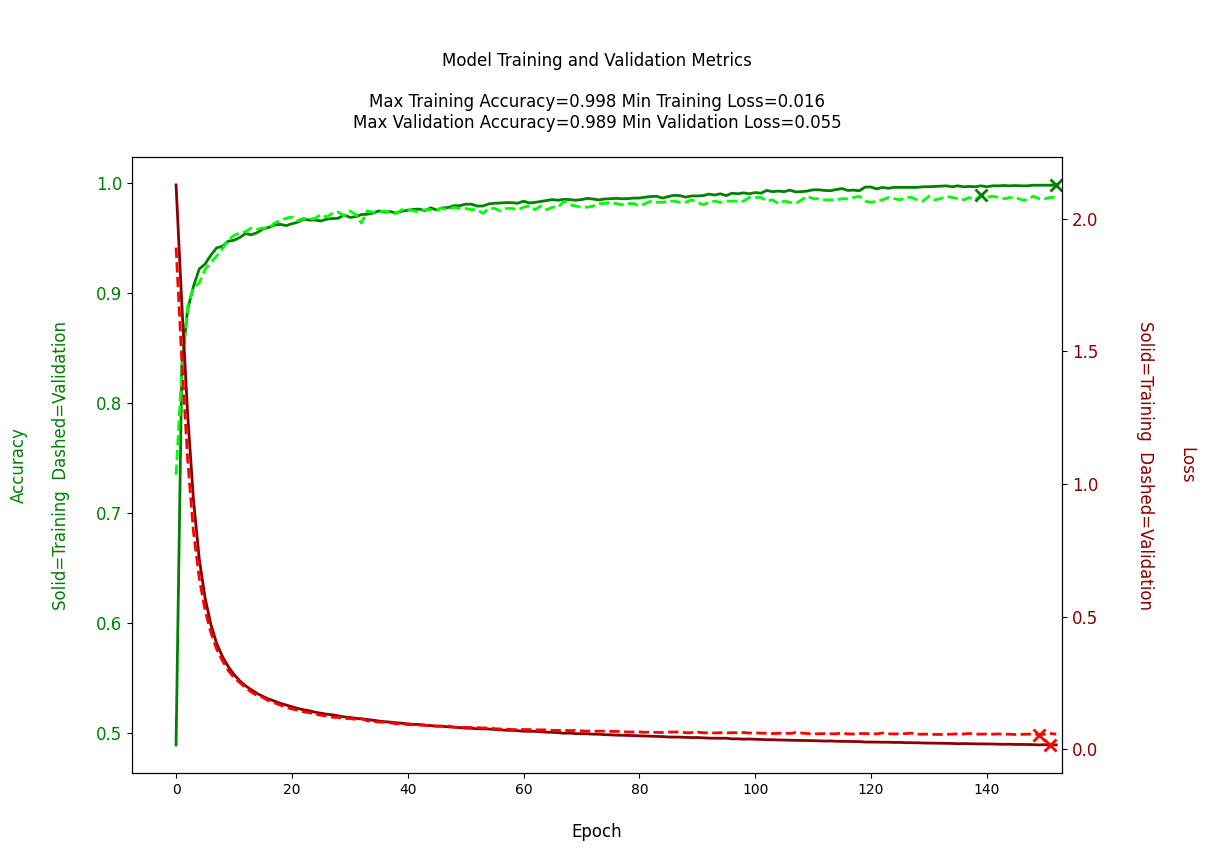

In [86]:
keras_plots(base_case_1_hist, len(base_case_1_hist.history['accuracy']))

In [87]:
base_1_test_results = base_case_1.predict(X_test)

preds = []
acts = []
for indx in range(base_1_test_results.shape[0]):
    prediction = np.argmax(base_1_test_results[indx])
    actual = np.argmax(y_test_k[indx])
    preds.append(prediction)
    acts.append(actual)

base_1_df = pd.DataFrame(list(zip(preds, acts)), columns =['Predictions', 'Actuals']) 

pd.crosstab(index=base_1_df["Predictions"], 
                            columns=base_1_df["Actuals"],
                            margins=False,
                            dropna=False) 

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step


Actuals        0    1    2    3    4    5    6    7    8    9
Predictions                                                  
0            111    0    0    0    0    0    0    0    0    0
1              0  112    0    0    0    0    0    0    0    1
2              0    0  109    0    0    1    0    0    0    0
3              0    0    1  112    0    1    0    0    0    0
4              0    1    0    0  114    0    1    0    2    3
5              0    0    0    0    0  108    0    0    0    0
6              0    0    0    0    0    0  111    0    0    0
7              0    0    0    0    0    0    0  112    0    1
8              0    1    0    0    0    1    0    1  108    1
9              0    0    1    2    0    1    0    0    1  106

<h5> Base Case 2 - No dropout, X_train vars Hidden Layer </h5>

In [88]:
tf.keras.backend.clear_session()

In [89]:
### Initialize Model
base_case_2 = tf.keras.models.Sequential()

output_layer = tf.keras.layers.Dense(output_size, activation = 'sigmoid', name = 'Output_Layer')

### Hidden Layer Set-Up
hidden_size = X_train.shape[1] 
hidden_layer_b2 = tf.keras.layers.Dense(hidden_size, input_dim = input_size, activation = 'sigmoid', name = 'Hidden_Layer')

### Add Layers
base_case_2.add(hidden_layer_b2)
base_case_2.add(output_layer)

### Add Compiler
base_case_2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

print(base_case_2.summary())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer (Dense)            │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,810 (18.79 KB)

 Trainable params: 4,810 (18.79 KB)

 Non-trainable params: 0 (0.00 B)

None


In [90]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    min_delta = 0.000001,  # Any change less than min delta will stop
    patience=20,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore the model weights best performance
    mode = 'min',
    start_from_epoch = 10
)

In [91]:
num_epochs = 10000        
validation_split = 0.2  
batch_size = 50                   
verbose = 1              

base_case_2_hist = base_case_2.fit(X_train, y_train_k, epochs=num_epochs, batch_size=batch_size, verbose=verbose,validation_split=validation_split, callbacks=[early_stopping])

Epoch 1/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2127 - loss: 2.3727 - val_accuracy: 0.6322 - val_loss: 2.0646
Epoch 2/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - accuracy: 0.6909 - loss: 1.9849 - val_accuracy: 0.8089 - val_loss: 1.7784
Epoch 3/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - accuracy: 0.8298 - loss: 1.6942 - val_accuracy: 0.8411 - val_loss: 1.4802
Epoch 4/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - accuracy: 0.8647 - loss: 1.3905 - val_accuracy: 0.8722 - val_loss: 1.2051
Epoch 5/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - accuracy: 0.8930 - loss: 1.1278 - val_accuracy: 0.8811 - val_loss: 0.9782
Epoch 6/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - accuracy: 0.8963 - loss: 0.9109 - val_accuracy: 0.9033 - val_loss: 0.8069
Epoch 7/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.9178 - loss: 0.7567 - val_accuracy: 0.9133 - val_loss: 0.6741
Epoch 8/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.9219 - loss: 0.6

In [92]:
base_case_2.evaluate(X_test, y_test_k)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step - accuracy: 0.9791 - loss: 0.0493


[0.05434736981987953, 0.9830960631370544]

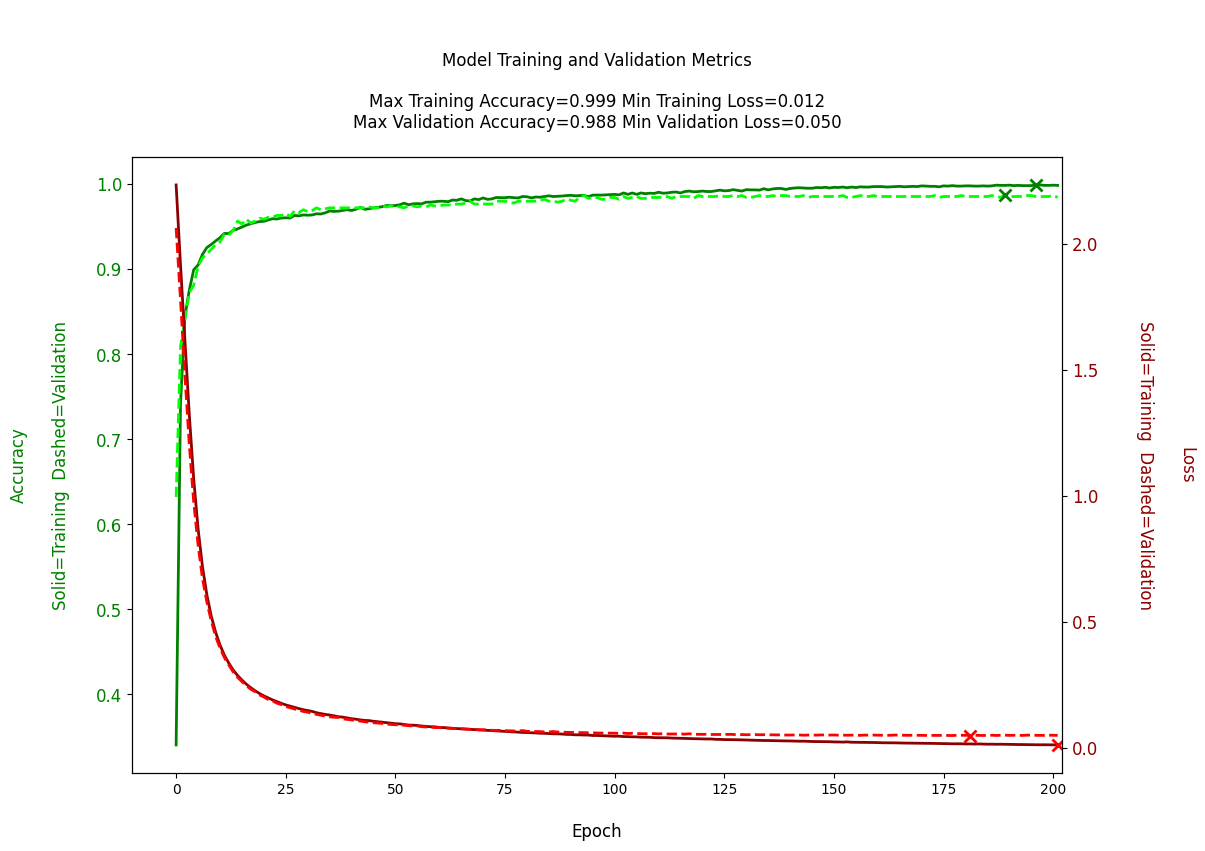

In [93]:
keras_plots(base_case_2_hist, len(base_case_2_hist.history['accuracy']))

In [94]:
base_2_test_results = base_case_2.predict(X_test)

preds = []
acts = []
for indx in range(base_2_test_results.shape[0]):
    prediction = np.argmax(base_2_test_results[indx])
    actual = np.argmax(y_test_k[indx])
    preds.append(prediction)
    acts.append(actual)

base_2_df = pd.DataFrame(list(zip(preds, acts)), columns =['Predictions', 'Actuals']) 

pd.crosstab(index=base_2_df["Predictions"], 
                            columns=base_2_df["Actuals"],
                            margins=False,
                            dropna=False) 

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step


Actuals        0    1    2    3    4    5    6    7    8    9
Predictions                                                  
0            111    0    0    0    0    0    0    0    0    0
1              0  113    0    0    0    0    0    0    0    1
2              0    0  109    0    0    1    0    0    0    0
3              0    0    1  113    0    1    0    0    0    0
4              0    0    0    0  113    0    1    0    2    3
5              0    0    0    0    0  110    0    0    0    1
6              0    0    0    0    0    0  111    0    0    0
7              0    0    0    0    0    0    0  112    0    1
8              0    0    0    0    0    0    0    1  108    1
9              0    1    1    1    1    0    0    0    1  105

<h5> Base Case 3 - No dropout, 1/2 * X_train vars Hidden Layer </h5>

In [95]:
tf.keras.backend.clear_session()

In [96]:
### Initialize Model
base_case_3 = tf.keras.models.Sequential()

output_layer = tf.keras.layers.Dense(output_size, activation = 'sigmoid', name = 'Output_Layer')

### Hidden Layer Set-Up
hidden_size = round(X_train.shape[1] * 0.5)
hidden_layer_b3 = tf.keras.layers.Dense(hidden_size, input_dim = input_size, activation = 'sigmoid', name = 'Hidden_Layer')

### Add Layers
base_case_3.add(hidden_layer_b3)
base_case_3.add(output_layer)

### Add Compiler
base_case_3.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

print(base_case_3.summary())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,410 (9.41 KB)

 Trainable params: 2,410 (9.41 KB)

 Non-trainable params: 0 (0.00 B)

None


In [97]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    min_delta = 0.000001,  # Any change less than min delta will stop
    patience=20,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore the model weights best performance
    mode = 'min',
    start_from_epoch = 10
)

In [98]:
num_epochs = 10000        
validation_split = 0.2  
batch_size = 50                   
verbose = 1              

base_case_3_hist = base_case_3.fit(X_train, y_train_k, epochs=num_epochs, batch_size=batch_size, verbose=verbose,validation_split=validation_split, callbacks=[early_stopping])

Epoch 1/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1595 - loss: 2.3163 - val_accuracy: 0.4644 - val_loss: 2.1415
Epoch 2/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - accuracy: 0.5261 - loss: 2.0919 - val_accuracy: 0.6478 - val_loss: 1.9472
Epoch 3/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.6711 - loss: 1.8876 - val_accuracy: 0.7356 - val_loss: 1.7368
Epoch 4/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.7674 - loss: 1.6760 - val_accuracy: 0.7844 - val_loss: 1.5314
Epoch 5/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.8075 - loss: 1.4649 - val_accuracy: 0.8200 - val_loss: 1.3345
Epoch 6/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.8499 - loss: 1.2742 - val_accuracy: 0.8511 - val_loss: 1.1574
Epoch 7/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.8714 - loss: 1.1054 - val_accuracy: 0.8744 - val_loss: 1.0045
Epoch 8/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.8976 - loss: 0.9

In [99]:
base_case_3.evaluate(X_test, y_test_k)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step - accuracy: 0.9827 - loss: 0.0469


[0.050528090447187424, 0.9857650995254517]

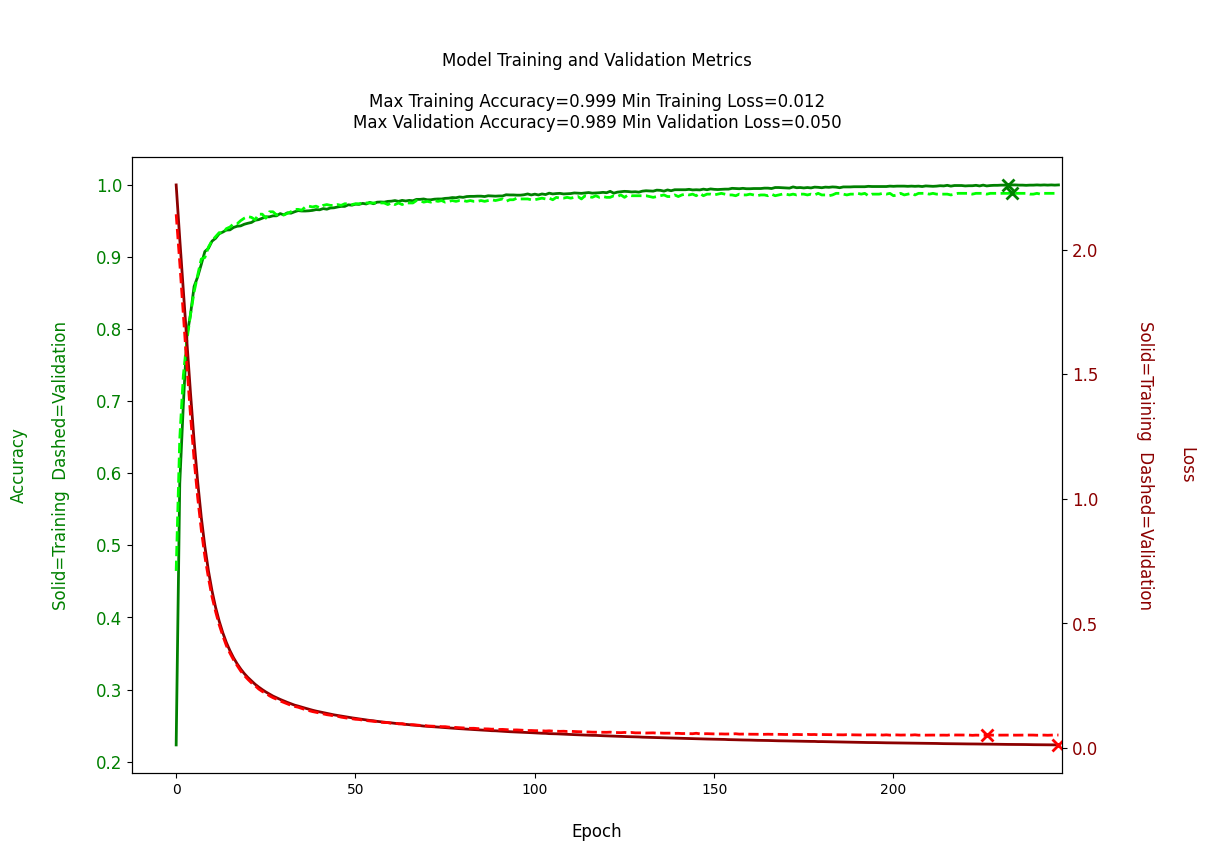

In [100]:
keras_plots(base_case_3_hist, len(base_case_3_hist.history['accuracy']))

In [101]:
base_3_test_results = base_case_3.predict(X_test)

preds = []
acts = []
for indx in range(base_3_test_results.shape[0]):
    prediction = np.argmax(base_3_test_results[indx])
    actual = np.argmax(y_test_k[indx])
    preds.append(prediction)
    acts.append(actual)

base_3_df = pd.DataFrame(list(zip(preds, acts)), columns =['Predictions', 'Actuals']) 

pd.crosstab(index=base_3_df["Predictions"], 
                            columns=base_3_df["Actuals"],
                            margins=False,
                            dropna=False) 

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step


Actuals        0    1    2    3    4    5    6    7    8    9
Predictions                                                  
0            111    0    0    0    0    0    0    0    0    0
1              0  112    0    0    0    0    0    0    0    1
2              0    0  110    0    0    0    0    0    0    0
3              0    0    1  113    0    1    0    0    0    0
4              0    0    0    0  114    0    1    0    2    3
5              0    0    0    0    0  111    0    0    0    0
6              0    0    0    0    0    0  111    0    0    0
7              0    0    0    0    0    0    0  112    0    1
8              0    2    0    0    0    0    0    1  108    1
9              0    0    0    1    0    0    0    0    1  106

In [102]:
base_case_1.save('./TF_Models/base_case_1.keras')
base_case_2.save('./TF_Models/base_case_2.keras')
base_case_3.save('./TF_Models/base_case_3.keras')

#### Static Dropouts

In [103]:
tf.keras.backend.clear_session()

In [104]:
### Static Dropout Layer Set-Up
sdr = 0.4 
dropout_layer_static = tf.keras.layers.Dropout(sdr, name = 'Dropout_Static')

<h5> Static Case 1 - Dropout = 0.4, 2 * X_train vars Hidden Layer </h5>

In [105]:
### Initialize Model
static_case_1 = tf.keras.models.Sequential()

output_layer = tf.keras.layers.Dense(output_size, activation = 'sigmoid', name = 'Output_Layer')

### Hidden Layer Set-Up
hidden_size = X_train.shape[1] * 2 
hidden_layer_s1 = tf.keras.layers.Dense(hidden_size, input_dim = input_size, activation = 'sigmoid', name = 'Hidden_Layer')

### Add Layers
static_case_1.add(hidden_layer_s1)
static_case_1.add(dropout_layer_static)
static_case_1.add(output_layer)

### Add Compiler
static_case_1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

print(static_case_1.summary())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer (Dense)            │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Static (Dropout)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,610 (37.54 KB)

 Trainable params: 9,610 (37.54 KB)

 Non-trainable params: 0 (0.00 B)

None


In [106]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    min_delta = 0.000001,  # Any change less than min delta will stop
    patience=20,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore the model weights best performance
    mode = 'min',
    start_from_epoch = 10
)

In [107]:
num_epochs = 10000        
validation_split = 0.2  
batch_size = 50                   
verbose = 1              

static_case_1_hist = static_case_1.fit(X_train, y_train_k, epochs=num_epochs, batch_size=batch_size, verbose=verbose,validation_split=validation_split, callbacks=[early_stopping])

Epoch 1/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1343 - loss: 2.3743 - val_accuracy: 0.7511 - val_loss: 1.9520
Epoch 2/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - accuracy: 0.3226 - loss: 1.9848 - val_accuracy: 0.8622 - val_loss: 1.6207
Epoch 3/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - accuracy: 0.5433 - loss: 1.6330 - val_accuracy: 0.8978 - val_loss: 1.3006
Epoch 4/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - accuracy: 0.6700 - loss: 1.3317 - val_accuracy: 0.8967 - val_loss: 1.0381
Epoch 5/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - accuracy: 0.7329 - loss: 1.1083 - val_accuracy: 0.9044 - val_loss: 0.8365
Epoch 6/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - accuracy: 0.7737 - loss: 0.9231 - val_accuracy: 0.9144 - val_loss: 0.6949
Epoch 7/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - accuracy: 0.8254 - loss: 0.7779 - val_accuracy: 0.9200 - val_loss: 0.5899
Epoch 8/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - accuracy: 0.8373 - loss: 0.6

In [108]:
static_case_1.evaluate(X_test, y_test_k)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step - accuracy: 0.9835 - loss: 0.0370


[0.041918475180864334, 0.9866548180580139]

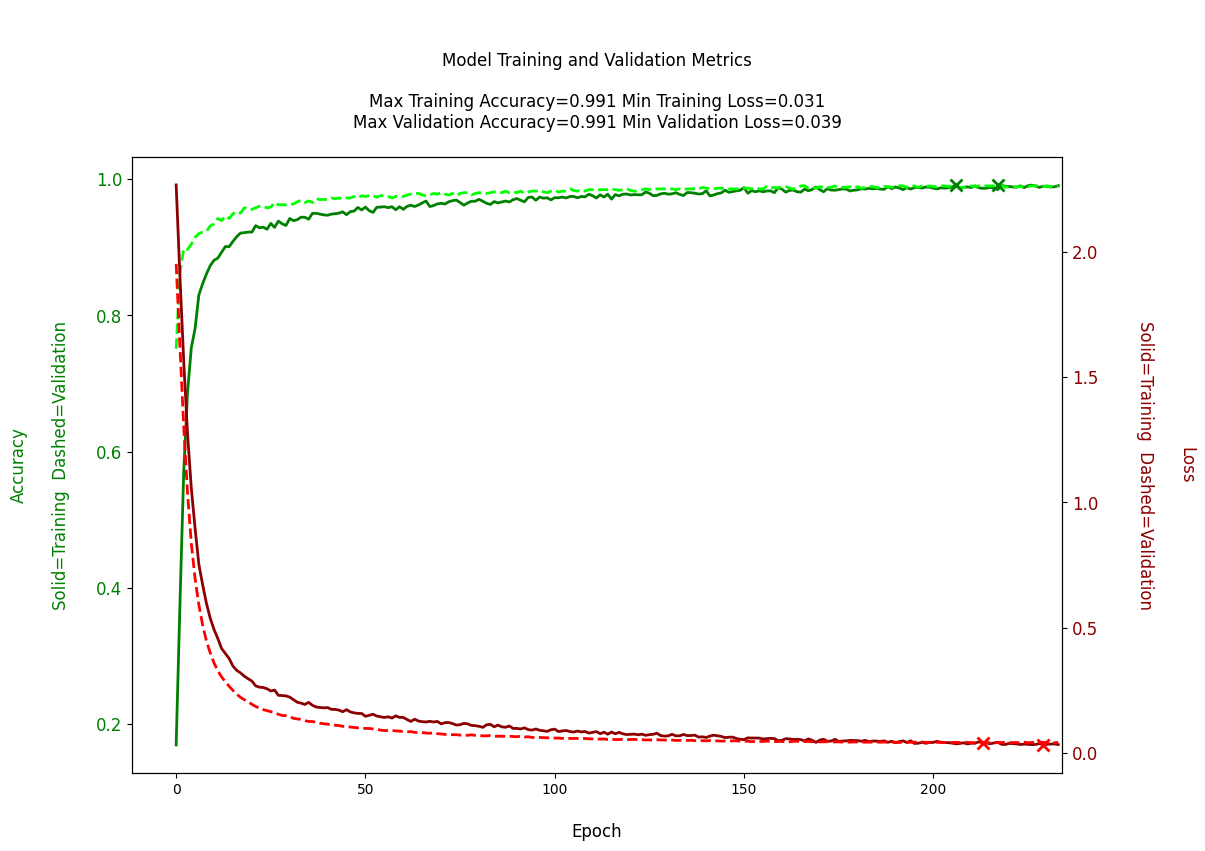

In [109]:
keras_plots(static_case_1_hist, len(static_case_1_hist.history['accuracy']))

In [110]:
static_1_test_results = static_case_1.predict(X_test)

preds = []
acts = []
for indx in range(static_1_test_results.shape[0]):
    prediction = np.argmax(static_1_test_results[indx])
    actual = np.argmax(y_test_k[indx])
    preds.append(prediction)
    acts.append(actual)

static_1_df = pd.DataFrame(list(zip(preds, acts)), columns =['Predictions', 'Actuals']) 

pd.crosstab(index=static_1_df["Predictions"], 
                            columns=static_1_df["Actuals"],
                            margins=False,
                            dropna=False) 

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step


Actuals        0    1    2    3    4    5    6    7    8    9
Predictions                                                  
0            111    0    0    0    0    0    0    0    0    0
1              0  112    0    0    0    0    0    0    0    0
2              0    0  110    0    0    0    0    0    0    0
3              0    0    1  113    0    1    0    0    0    0
4              0    0    0    0  114    0    1    0    2    3
5              0    0    0    0    0  110    0    0    0    0
6              0    0    0    0    0    0  111    0    0    0
7              0    0    0    0    0    0    0  112    0    0
8              0    2    0    0    0    0    0    1  108    1
9              0    0    0    1    0    1    0    0    1  108

<h5> Static Case 2 - Dropout = 0.4, 1/2 * X_train vars Hidden Layer </h5>

In [111]:
tf.keras.backend.clear_session()

In [112]:
### Initialize Model
static_case_2 = tf.keras.models.Sequential()

output_layer = tf.keras.layers.Dense(output_size, activation = 'sigmoid', name = 'Output_Layer')

### Hidden Layer Set-Up
hidden_size = round(X_train.shape[1] * 0.5)
hidden_layer_s2 = tf.keras.layers.Dense(hidden_size, input_dim = input_size, activation = 'sigmoid', name = 'Hidden_Layer')

### Add Layers
static_case_2.add(hidden_layer_s2)
static_case_2.add(dropout_layer_static)
static_case_2.add(output_layer)

### Add Compiler
static_case_2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

print(static_case_2.summary())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Static (Dropout)        │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,410 (9.41 KB)

 Trainable params: 2,410 (9.41 KB)

 Non-trainable params: 0 (0.00 B)

None


In [113]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    min_delta = 0.000001,  # Any change less than min delta will stop
    patience=20,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore the model weights best performance
    mode = 'min',
    start_from_epoch = 10
)

In [114]:
num_epochs = 10000        
validation_split = 0.2  
batch_size = 50                   
verbose = 1              

static_case_2_hist = static_case_2.fit(X_train, y_train_k, epochs=num_epochs, batch_size=batch_size, verbose=verbose,validation_split=validation_split,callbacks=[early_stopping])

Epoch 1/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1044 - loss: 2.4911 - val_accuracy: 0.2878 - val_loss: 2.2043
Epoch 2/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - accuracy: 0.1768 - loss: 2.2284 - val_accuracy: 0.6733 - val_loss: 2.0628
Epoch 3/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.2766 - loss: 2.0836 - val_accuracy: 0.7833 - val_loss: 1.9111
Epoch 4/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.3711 - loss: 1.9354 - val_accuracy: 0.8200 - val_loss: 1.7441
Epoch 5/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.4752 - loss: 1.7818 - val_accuracy: 0.8444 - val_loss: 1.5697
Epoch 6/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.5228 - loss: 1.6170 - val_accuracy: 0.8544 - val_loss: 1.4031
Epoch 7/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.5889 - loss: 1.4862 - val_accuracy: 0.8678 - val_loss: 1.2548
Epoch 8/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.6423 - loss: 1.3

In [115]:
static_case_2.evaluate(X_test, y_test_k)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step - accuracy: 0.9815 - loss: 0.0528


[0.06609166413545609, 0.9786477088928223]

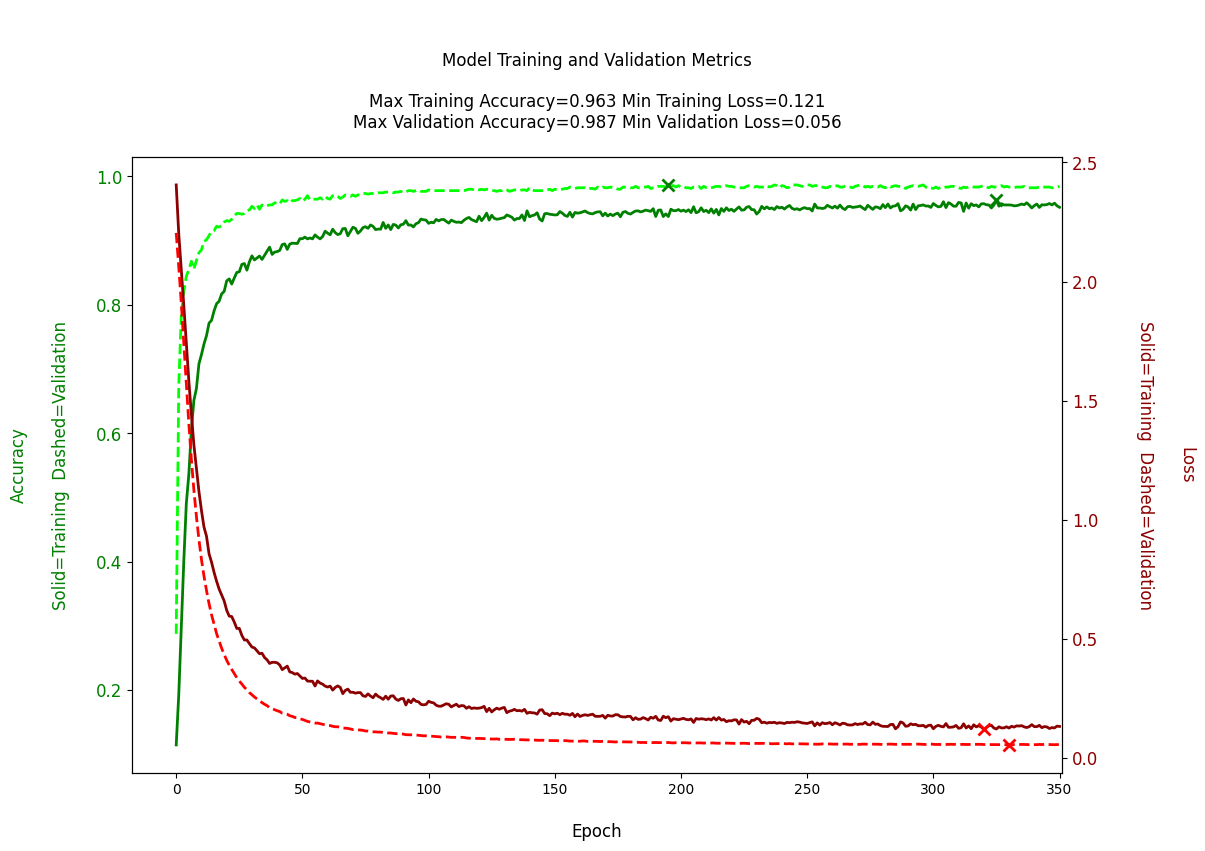

In [116]:
keras_plots(static_case_2_hist, len(static_case_2_hist.history['accuracy']))

In [117]:
static_2_test_results = static_case_2.predict(X_test)

preds = []
acts = []
for indx in range(static_2_test_results.shape[0]):
    prediction = np.argmax(static_2_test_results[indx])
    actual = np.argmax(y_test_k[indx])
    preds.append(prediction)
    acts.append(actual)

static_2_df = pd.DataFrame(list(zip(preds, acts)), columns =['Predictions', 'Actuals']) 

pd.crosstab(index=static_2_df["Predictions"], 
                            columns=static_2_df["Actuals"],
                            margins=False,
                            dropna=False) 

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step


Actuals        0    1    2    3    4    5    6    7    8    9
Predictions                                                  
0            111    0    0    0    0    0    0    0    0    0
1              0  114    0    0    0    0    0    0    0    1
2              0    0  108    0    0    1    0    0    1    0
3              0    0    1  111    0    1    0    0    0    1
4              0    0    0    0  114    0    1    0    2    4
5              0    0    1    0    0  109    0    0    0    0
6              0    0    0    0    0    0  111    0    0    0
7              0    0    0    0    0    0    0  113    0    2
8              0    0    1    0    0    0    0    0  106    1
9              0    0    0    3    0    1    0    0    2  103

<h5> Static Case 3 - Dropout = 0.4, X_train vars Hidden Layer </h5>

In [118]:
tf.keras.backend.clear_session()

In [119]:
### Initialize Model
static_case_3 = tf.keras.models.Sequential()

output_layer = tf.keras.layers.Dense(output_size, activation = 'sigmoid', name = 'Output_Layer')

### Hidden Layer Set-Up
hidden_size = X_train.shape[1]
hidden_layer_s3 = tf.keras.layers.Dense(hidden_size, input_dim = input_size, activation = 'sigmoid', name = 'Hidden_Layer')

### Add Layers
static_case_3.add(hidden_layer_s3)
static_case_3.add(dropout_layer_static)
static_case_3.add(output_layer)

### Add Compiler
static_case_3.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

print(static_case_3.summary())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer (Dense)            │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Static (Dropout)        │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,810 (18.79 KB)

 Trainable params: 4,810 (18.79 KB)

 Non-trainable params: 0 (0.00 B)

None


In [120]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    min_delta = 0.000001,  # Any change less than min delta will stop
    patience=20,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore the model weights best performance
    mode = 'min',
    start_from_epoch = 10
)

In [121]:
num_epochs = 10000        
validation_split = 0.2 
batch_size = 50                   
verbose = 1              

static_case_3_hist = static_case_3.fit(X_train, y_train_k, epochs=num_epochs, batch_size=batch_size, verbose=verbose,validation_split=validation_split,callbacks=[early_stopping])

Epoch 1/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1362 - loss: 2.3855 - val_accuracy: 0.6478 - val_loss: 2.0447
Epoch 2/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - accuracy: 0.2618 - loss: 2.0884 - val_accuracy: 0.8022 - val_loss: 1.8137
Epoch 3/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.4132 - loss: 1.8524 - val_accuracy: 0.8300 - val_loss: 1.5752
Epoch 4/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.5307 - loss: 1.6197 - val_accuracy: 0.8733 - val_loss: 1.3463
Epoch 5/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6393 - loss: 1.3953 - val_accuracy: 0.8800 - val_loss: 1.1464
Epoch 6/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.6682 - loss: 1.2618 - val_accuracy: 0.8878 - val_loss: 0.9846
Epoch 7/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - accuracy: 0.7383 - loss: 1.0794 - val_accuracy: 0.8956 - val_loss: 0.8493
Epoch 8/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - accuracy: 0.7723 - loss: 0.9

In [122]:
static_case_3.evaluate(X_test, y_test_k)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step - accuracy: 0.9867 - loss: 0.0409


[0.047278568148612976, 0.9875444769859314]

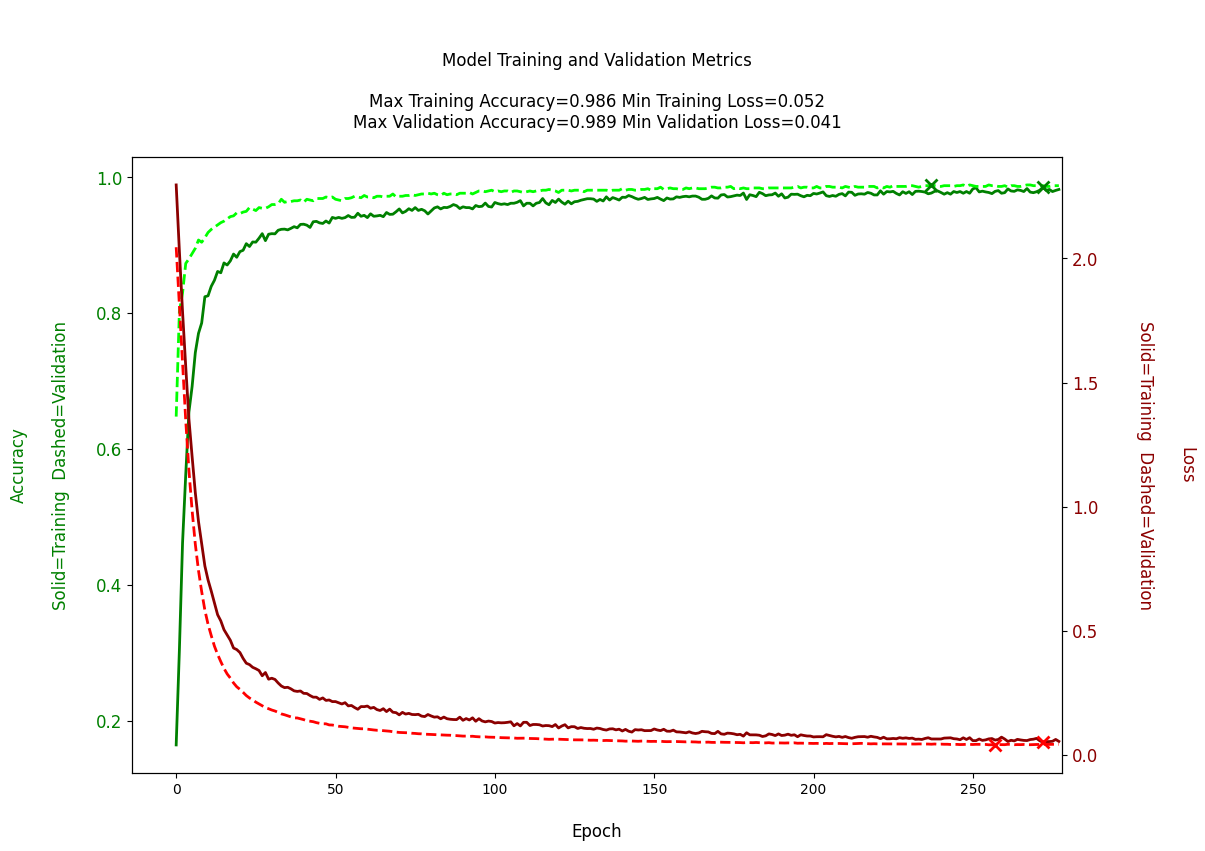

In [123]:
keras_plots(static_case_3_hist, len(static_case_3_hist.history['accuracy']))

In [124]:
static_3_test_results = static_case_3.predict(X_test)

preds = []
acts = []
for indx in range(static_3_test_results.shape[0]):
    prediction = np.argmax(static_3_test_results[indx])
    actual = np.argmax(y_test_k[indx])
    preds.append(prediction)
    acts.append(actual)

static_3_df = pd.DataFrame(list(zip(preds, acts)), columns =['Predictions', 'Actuals']) 

pd.crosstab(index=static_3_df["Predictions"], 
                            columns=static_3_df["Actuals"],
                            margins=False,
                            dropna=False) 

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step


Actuals        0    1    2    3    4    5    6    7    8    9
Predictions                                                  
0            111    0    0    0    0    0    0    0    0    0
1              0  114    0    0    0    0    0    0    0    0
2              0    0  110    0    0    0    0    0    0    0
3              0    0    0  113    0    1    0    0    0    0
4              0    0    0    0  113    0    1    0    2    3
5              0    0    0    0    0  110    0    0    0    0
6              0    0    0    0    0    0  111    0    0    0
7              0    0    0    0    0    0    0  112    0    0
8              0    0    0    0    1    0    0    1  108    1
9              0    0    1    1    0    1    0    0    1  108

In [125]:
static_case_1.save('./TF_Models/static_case_1.keras')
static_case_2.save('./TF_Models/static_case_2.keras')
static_case_3.save('./TF_Models/static_case_3.keras')

#### Dynamic Dropouts

##### Dynamic Dropout Callback Code

In [250]:
### Building a dyanmic dropout layer in Keras

class DropoutScheduler(tf.keras.callbacks.Callback):
    def __init__(self, error_rate):
        self.error_rate = error_rate

    def on_epoch_end(self, epoch, logs=None):
        if epoch > 0:
            for layer in self.model.layers:
                if isinstance(layer, tf.keras.layers.Dropout):
                    curr_rate = layer.rate
                    # print(f'Current Dropout Rate is {'{:.2%}'.format(curr_rate)}')

            loss = logs.get('loss')
            print(f'Current Loss: {'{:.2%}'.format(loss)}')
            new_rate = 1 - logs.get('loss')

            ### Set the new rate to 10% if below 10% else assign dropout equal to the loss of the prior layer
            if loss < 0.1:
                new_rate = 0.9
            elif loss > 1:
                new_rate = 1

            # ### small model condition with too many nodes turned off
            if isinstance(layer, tf.keras.layers.Dense):
                hlayer_size = self.model.get_layer('Hidden_Layer').units * input_size
                # print(hlayer_size)

            if hlayer_size < 10 and new_rate > 0.5:
                new_rate = 0.5

            # or if it exceeds 75% of the nodes shut off, 
            elif (hlayer_size - (hlayer_size * new_rate)) < (hlayer_size * 0.25):
                new_rate = 0.25 

            ### Update rate and print new rate
            if new_rate is not None:
                for layer in self.model.layers:
                    if isinstance(layer, tf.keras.layers.Dropout):
                        layer.rate = new_rate
                        print(f'New Dropout Rate is {'{:.2%}'.format(new_rate)}\n')
            else:
                print("Loss in logs not found\n")
            
    
    ### print again at the beginning of the next Epoch
    def on_epoch_begin(self, epoch, logs=None):
        if epoch > 0:
            for layer in self.model.layers:
                if isinstance(layer, tf.keras.layers.Dropout):
                    print(f'Epoch {epoch}\nCurrent Dropout Rate is {'{:.2%}'.format(layer.rate)}')


### Experiments

<h5> Dynamic Case 1 - Dropout Dynamic, 2 * X_train vars Hidden Layer </h5>

In [251]:
tf.keras.backend.clear_session()

In [252]:
sdr = 0.0001 
dropout_scheduler = DropoutScheduler(error_rate = sdr)

In [253]:
### Initialize Model
dyn_case_1 = tf.keras.models.Sequential()

output_layer = tf.keras.layers.Dense(output_size, activation = 'sigmoid', name = 'Output_Layer')

### Hidden Layer Set-Up
hidden_size = X_train.shape[1] * 2 
hidden_layer_d1 = tf.keras.layers.Dense(hidden_size, input_dim = input_size, activation = 'sigmoid', name = 'Hidden_Layer')

### Dynamic Dropout Layer Set-Up
### set an initial rate with a very small dropout percent
sdr = 0.0001 
dropout_layer_dynamic_1 = tf.keras.layers.Dropout(sdr, name = 'Dropout_Dynamic')

### Add Layers
dyn_case_1.add(hidden_layer_d1)
dyn_case_1.add(dropout_layer_dynamic_1)
dyn_case_1.add(output_layer)

### Add Compiler
dyn_case_1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

print(dyn_case_1.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer (Dense)            │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Dynamic (Dropout)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,610 (37.54 KB)

 Trainable params: 9,610 (37.54 KB)

 Non-trainable params: 0 (0.00 B)

None


In [254]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    min_delta = 0.000001,  # Any change less than min delta will stop
    patience=20,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore the model weights best performance
    mode = 'min',
    start_from_epoch = 10
)

In [255]:
num_epochs = 10000        
validation_split = 0.2  
batch_size = 50                   
verbose = 0              

dyn_case_1_hist = dyn_case_1.fit(X_train, y_train_k, epochs=num_epochs, batch_size=batch_size, verbose=verbose,validation_split=validation_split,callbacks=[dropout_scheduler,early_stopping])

Epoch 1
Current Dropout Rate is 0.01%
Current Loss: 167.83%
New Dropout Rate is 25.00%

Epoch 2
Current Dropout Rate is 25.00%
Current Loss: 127.74%
New Dropout Rate is 25.00%

Epoch 3
Current Dropout Rate is 25.00%
Current Loss: 95.77%
New Dropout Rate is 4.23%

Epoch 4
Current Dropout Rate is 4.23%
Current Loss: 73.42%
New Dropout Rate is 26.58%

Epoch 5
Current Dropout Rate is 26.58%
Current Loss: 58.69%
New Dropout Rate is 41.31%

Epoch 6
Current Dropout Rate is 41.31%
Current Loss: 48.36%
New Dropout Rate is 51.64%

Epoch 7
Current Dropout Rate is 51.64%
Current Loss: 41.15%
New Dropout Rate is 58.85%

Epoch 8
Current Dropout Rate is 58.85%
Current Loss: 35.88%
New Dropout Rate is 64.12%

Epoch 9
Current Dropout Rate is 64.12%
Current Loss: 31.96%
New Dropout Rate is 68.04%

Epoch 10
Current Dropout Rate is 68.04%
Current Loss: 28.95%
New Dropout Rate is 71.05%

Epoch 11
Current Dropout Rate is 71.05%
Current Loss: 26.40%
New Dropout Rate is 73.60%

Epoch 12
Current Dropout Rate i

In [256]:
dyn_case_1.evaluate(X_test, y_test_k)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.9791 - loss: 0.0534


[0.05607599392533302, 0.982206404209137]

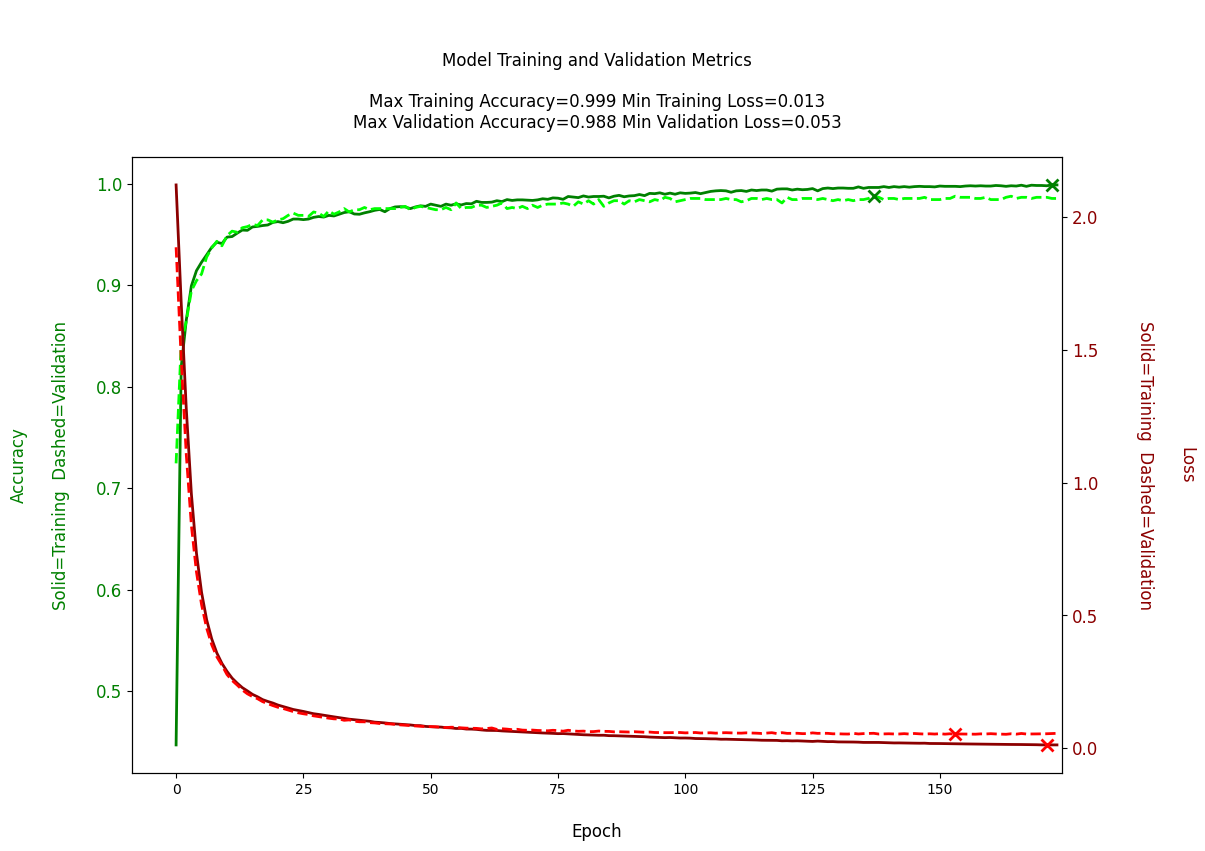

In [257]:
keras_plots(dyn_case_1_hist, len(dyn_case_1_hist.history['accuracy']))

In [258]:
dyn1_test_results = dyn_case_1.predict(X_test)

preds = []
acts = []
for indx in range(dyn1_test_results.shape[0]):
    prediction = np.argmax(dyn1_test_results[indx])
    actual = np.argmax(y_test_k[indx])
    preds.append(prediction)
    acts.append(actual)

dyn_1_df = pd.DataFrame(list(zip(preds, acts)), columns =['Predictions', 'Actuals']) 

pd.crosstab(index=dyn_1_df["Predictions"], 
                            columns=dyn_1_df["Actuals"],
                            margins=False,
                            dropna=False) 

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step


Actuals        0    1    2    3    4    5    6    7    8    9
Predictions                                                  
0            111    0    0    0    0    0    0    0    0    0
1              0  113    0    0    0    0    0    0    0    1
2              0    0  109    0    0    0    0    0    0    0
3              0    0    1  113    0    1    0    0    0    0
4              0    0    0    0  114    0    1    0    2    4
5              0    0    0    0    0  109    0    0    0    0
6              0    0    0    0    0    0  111    0    0    0
7              0    0    0    0    0    0    0  112    0    2
8              0    1    0    0    0    1    0    1  108    1
9              0    0    1    1    0    1    0    0    1  104

<h5> Dynamic Case 2 - Dropout Dynamic, 1/2 * X_train vars Hidden Layer </h5>

In [259]:
tf.keras.backend.clear_session()

In [260]:
### Initialize Model
dyn_case_2 = tf.keras.models.Sequential()

output_layer = tf.keras.layers.Dense(output_size, activation = 'sigmoid', name = 'Output_Layer')

### Hidden Layer Set-Up
hidden_size = round(X_train.shape[1] * 0.5)
hidden_layer_s2 = tf.keras.layers.Dense(hidden_size, input_dim = input_size, activation = 'sigmoid', name = 'Hidden_Layer')

### Dynamic Dropout Layer Set-Up
### set an initial rate with a very small dropout percent
sdr = 0.0001 
dropout_layer_dynamic_2 = tf.keras.layers.Dropout(sdr, name = 'Dropout_Dynamic')

### Add Layers
dyn_case_2.add(hidden_layer_s2)
dyn_case_2.add(dropout_layer_dynamic_2)
dyn_case_2.add(output_layer)

### Add Compiler
dyn_case_2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

print(dyn_case_2.summary())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Dynamic (Dropout)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,410 (9.41 KB)

 Trainable params: 2,410 (9.41 KB)

 Non-trainable params: 0 (0.00 B)

None


In [261]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    min_delta = 0.000001,  # Any change less than min delta will stop
    patience=20,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore the model weights best performance
    mode = 'min',
    start_from_epoch = 10
)

In [262]:
num_epochs = 10000        
validation_split = 0.2  
batch_size = 50                   
verbose = 1              

dyn_case_2_hist = dyn_case_2.fit(X_train, y_train_k, epochs=num_epochs, batch_size=batch_size, verbose=verbose,validation_split=validation_split,callbacks=[dropout_scheduler,early_stopping])

Epoch 1/10000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1092 - loss: 2.3781 - val_accuracy: 0.3278 - val_loss: 2.1670
Epoch 1
Current Dropout Rate is 0.01%
Epoch 2/10000
 1/72 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4000 - loss: 2.1564Current Loss: 206.95%
New Dropout Rate is 25.00%

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.4756 - loss: 2.1146 - val_accuracy: 0.6933 - val_loss: 1.9678
Epoch 2
Current Dropout Rate is 25.00%
Epoch 3/10000
 1/72 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6400 - loss: 1.9526Current Loss: 186.12%
New Dropout Rate is 25.00%

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.7321 - loss: 1.9137 - val_accuracy: 0.7567 - val_loss: 1.7537
Epoch 3
Current Dropout Rate is 25.00%
Epoch 4/10000
 1/72 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6800 - loss: 1.8073Current Loss: 163.81%
New Dropout Rate is 25.00%

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - accuracy: 0.8122 - loss: 1.7034 - val_accuracy: 0.7900 - val_loss: 1.5

In [263]:
dyn_case_2.evaluate(X_test, y_test_k)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step - accuracy: 0.9827 - loss: 0.0503


[0.05480673909187317, 0.9839857816696167]

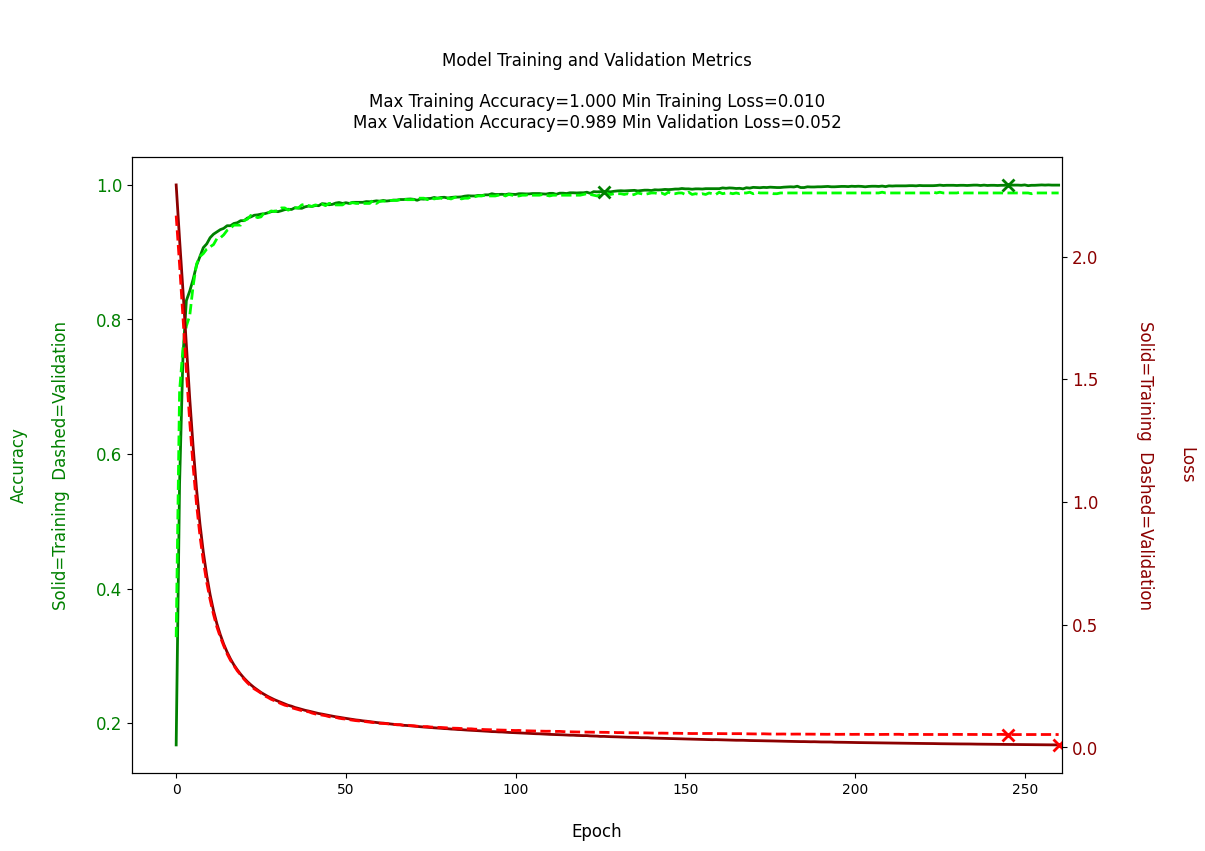

In [264]:
keras_plots(dyn_case_2_hist, len(dyn_case_2_hist.history['accuracy']))

In [265]:
dyn2_test_results = dyn_case_2.predict(X_test)

preds = []
acts = []
for indx in range(dyn2_test_results.shape[0]):
    prediction = np.argmax(dyn2_test_results[indx])
    actual = np.argmax(y_test_k[indx])
    preds.append(prediction)
    acts.append(actual)

dyn_2_df = pd.DataFrame(list(zip(preds, acts)), columns =['Predictions', 'Actuals']) 

pd.crosstab(index=dyn_2_df["Predictions"], 
                            columns=dyn_2_df["Actuals"],
                            margins=False,
                            dropna=False) 

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step


Actuals        0    1    2    3    4    5    6    7    8    9
Predictions                                                  
0            111    0    0    0    0    0    0    0    0    0
1              0  114    0    0    0    0    0    0    0    1
2              0    0  110    0    0    1    0    0    0    0
3              0    0    1  113    0    1    0    0    0    0
4              0    0    0    0  114    0    1    1    2    4
5              0    0    0    0    0  108    0    0    0    0
6              0    0    0    0    0    0  111    0    0    0
7              0    0    0    0    0    0    0  111    0    0
8              0    0    0    0    0    1    0    1  108    1
9              0    0    0    1    0    1    0    0    1  106

<h5> Dynamic Case 3 - Dropout Dynamic, X_train vars Hidden Layer </h5>

In [266]:
tf.keras.backend.clear_session()

In [267]:
### Initialize Model
dyn_case_3 = tf.keras.models.Sequential()

output_layer = tf.keras.layers.Dense(output_size, activation = 'sigmoid', name = 'Output_Layer')

### Hidden Layer Set-Up
hidden_size = X_train.shape[1]
hidden_layer_s3 = tf.keras.layers.Dense(hidden_size, input_dim = input_size, activation = 'sigmoid', name = 'Hidden_Layer')

### Dynamic Dropout Layer Set-Up
### set an initial rate with a very small dropout percent
sdr = 0.0001 
dropout_layer_dynamic_3 = tf.keras.layers.Dropout(sdr, name = 'Dropout_Dynamic')

### Add Layers
dyn_case_3.add(hidden_layer_s3)
dyn_case_3.add(dropout_layer_dynamic_3)
dyn_case_3.add(output_layer)

### Add Compiler
dyn_case_3.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

print(dyn_case_3.summary())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer (Dense)            │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Dynamic (Dropout)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,810 (18.79 KB)

 Trainable params: 4,810 (18.79 KB)

 Non-trainable params: 0 (0.00 B)

None


In [268]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    min_delta = 0.000001,  # Any change less than min delta will stop
    patience=20,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore the model weights best performance
    mode = 'min',
    start_from_epoch = 10
)

In [269]:
num_epochs = 10000        
validation_split = 0.2 
batch_size = 50                   
verbose = 0              

dyn_case_3_hist = dyn_case_3.fit(X_train, y_train_k, epochs=num_epochs, batch_size=batch_size, verbose=verbose,validation_split=validation_split,callbacks=[dropout_scheduler,early_stopping])

Epoch 1
Current Dropout Rate is 0.01%
Current Loss: 191.22%
New Dropout Rate is 25.00%

Epoch 2
Current Dropout Rate is 25.00%
Current Loss: 159.54%
New Dropout Rate is 25.00%

Epoch 3
Current Dropout Rate is 25.00%
Current Loss: 129.28%
New Dropout Rate is 25.00%

Epoch 4
Current Dropout Rate is 25.00%
Current Loss: 103.94%
New Dropout Rate is 25.00%

Epoch 5
Current Dropout Rate is 25.00%
Current Loss: 84.44%
New Dropout Rate is 15.56%

Epoch 6
Current Dropout Rate is 15.56%
Current Loss: 69.90%
New Dropout Rate is 30.10%

Epoch 7
Current Dropout Rate is 30.10%
Current Loss: 59.03%
New Dropout Rate is 40.97%

Epoch 8
Current Dropout Rate is 40.97%
Current Loss: 50.83%
New Dropout Rate is 49.17%

Epoch 9
Current Dropout Rate is 49.17%
Current Loss: 44.70%
New Dropout Rate is 55.30%

Epoch 10
Current Dropout Rate is 55.30%
Current Loss: 39.73%
New Dropout Rate is 60.27%

Epoch 11
Current Dropout Rate is 60.27%
Current Loss: 35.89%
New Dropout Rate is 64.11%

Epoch 12
Current Dropout Ra

In [270]:
dyn_case_3.evaluate(X_test, y_test_k)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step - accuracy: 0.9802 - loss: 0.0515


[0.05373246967792511, 0.9848754405975342]

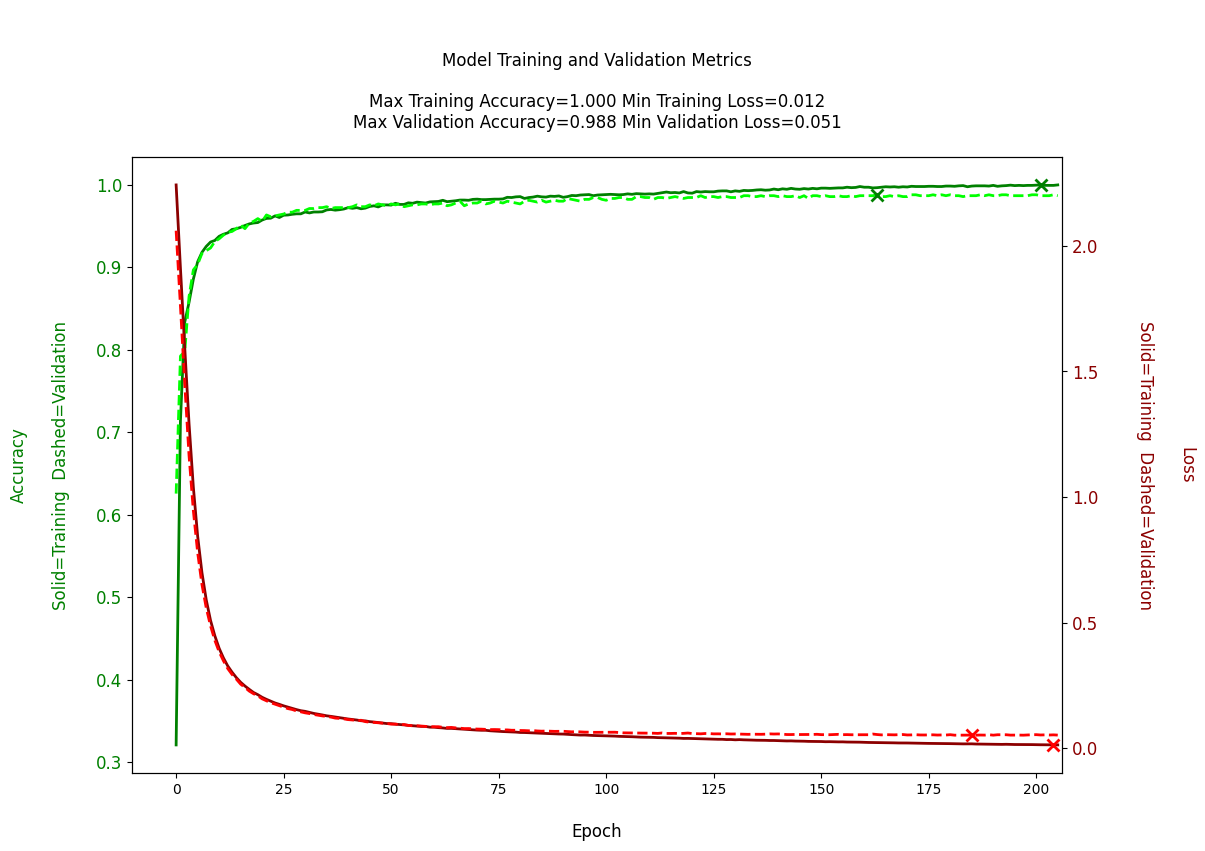

In [271]:
keras_plots(dyn_case_3_hist, len(dyn_case_3_hist.history['accuracy']))

In [272]:
dyn3_test_results = dyn_case_3.predict(X_test)

preds = []
acts = []
for indx in range(dyn3_test_results.shape[0]):
    prediction = np.argmax(dyn3_test_results[indx])
    actual = np.argmax(y_test_k[indx])
    preds.append(prediction)
    acts.append(actual)

dyn_3_df = pd.DataFrame(list(zip(preds, acts)), columns =['Predictions', 'Actuals']) 

pd.crosstab(index=dyn_3_df["Predictions"], 
                            columns=dyn_3_df["Actuals"],
                            margins=False,
                            dropna=False) 

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step


Actuals        0    1    2    3    4    5    6    7    8    9
Predictions                                                  
0            111    0    0    0    0    0    0    0    0    0
1              0  112    0    0    0    0    0    0    0    1
2              0    0  110    0    0    1    0    0    0    0
3              0    0    1  113    0    1    0    0    0    0
4              0    0    0    0  114    0    1    0    2    3
5              0    0    0    0    0  109    0    0    0    0
6              0    0    0    0    0    0  111    0    0    0
7              0    0    0    0    0    0    0  112    0    1
8              0    2    0    0    0    0    0    1  109    1
9              0    0    0    1    0    1    0    0    0  106

In [273]:
dyn_case_1.save('./TF_Models/dyn_case_1.keras')
dyn_case_2.save('./TF_Models/dyn_case_2.keras')
dyn_case_3.save('./TF_Models/dyn_case_3.keras')

In [ ]:
### To reload

## dyn_case_3 = tf.keras.models.load_model('./TF_Models/dyn_case_3.keras')

## Dyanmic Dropout with Tensorflow (DO NOT RUN testing only)

tf.keras.backend.clear_session()

### Model Case 1
ddri = 0.0001 # making the initial drop out rate very small almost to be 0

### Initialize Model
a1_model_case1 = tf.keras.models.Sequential()

### Create Dropout
dropout_dynamic = tf.keras.layers.Dropout(ddri, name = 'Dropout_Dynamic')

### Add Layers
a1_model_case1.add(hidden1)
a1_model_case1.add(dropout_dynamic)
a1_model_case1.add(outputs)

### Add Compiler
a1_model_case1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

print(a1_model_case1.summary())

### new one
dropout_scheduler = DropoutScheduler(error_rate = ddri)

#### testing code only
num_epochs = 100      
validation_split = 0.25  
batch_size = 50                   
verbose = 0     

a1_case1_hist_b = a1_model_case1.fit(X_train, y_train_k, epochs=100, 
                                   batch_size=batch_size, verbose=verbose,
                                   validation_split=validation_split, callbacks=[dropout_scheduler,tensorboard_callback])

a1_model_case1.evaluate(X_test, y_test_k)

max(a1_case1_hist.history['val_accuracy'])

max(a1_case1_hist.history['accuracy'])

import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

##### Tensor Board (Testing Only)

num_epochs = 1000        
validation_split = 0.25  
batch_size = 50                   
verbose = 0     

a1_case1_hist = a1_model_case1.fit(X_train, y_train_k, epochs=num_epochs, 
                                   batch_size=batch_size, verbose=verbose,
                                   validation_split=validation_split, callbacks=[dropout_scheduler,tensorboard_callback])

%tensorboard --logdir logs/fit

from tensorboard.plugins.hparams import api as hp